# Final Project - Exploring FOMC Sentiment and Manufacturing New Orders

This project investigates whether the tone of Federal Open Market Committee (FOMC) communications can improve forecasts of monthly U.S. manufacturing new orders. I construct two dictionary-based sentiment indices from FOMC minutes and statements using a curated economic vocabulary and explore their predictive value alongside traditional macroeconomic indicators (e.g., PPI, oil prices, CPI, unemployment). Finding that sentiment scores alone explain little variance in the target, I develop a multi-stage unsupervised pipeline, including TF–IDF clustering, BERTopic, FinBERT tone detection, and PCA, to extract latent textual features from Fed communications. I integrate these with macro series and autoregressive lags into a Random Forest model that achieves high out-of-sample performance (R² = 0.9835, RMSE = 0.042). Despite the rich text-mining framework, results show that realized fundamentals, especially cost pressures and order momentum, remain the dominant drivers of manufacturing behavior, while FOMC tone contributes only marginally. This suggests that while central-bank rhetoric shapes expectations, it exerts limited influence on high-frequency production planning. I conclude that sentiment features may be more useful for structural regime classification than for real-time forecasting of industrial outcomes.

## Part 1: FOMC Data Ingestion and Reshaping

- **Data Source:** `communications.csv` containing all FOMC Statements and Minutes since 2000.
- **Goal:** Prepare a dataset with separate columns for each document type per FOMC date.
- **Key Steps:**
  - Load the CSV and inspect structure.
  - Filter for `Date`, `Type`, and `Text`.
  - Pivot into a wide format with one row per meeting date.
  - Fill in missing entries with empty strings.
  - Adjust the date (if the day is after the 27th) into the next month to better align with monthly economic data.
  - Remove duplicate `Date` entries.
  - Final format uses `"YYYY/MM"` strings.

In [ ]:
# read communications.csv
import pandas as pd
df = pd.read_csv('communications.csv')

In [ ]:
# see what the data looks like
df.head(10)

,Date,Release Date,Type,Text
0,2025-03-19,2025-04-09,Minute,Minutes of the Federal Open Market Committee\n...
1,2025-03-19,2025-03-19,Statement,Recent indicators suggest that economic activi...
2,2025-01-29,2025-01-29,Statement,Recent indicators suggest that economic activi...
3,2025-01-29,2025-02-19,Minute,Minutes of the Federal Open Market Committee\n...
4,2024-12-18,2024-12-18,Statement,Recent indicators suggest that economic activi...
5,2024-12-18,2025-01-08,Minute,Minutes of the Federal Open Market Committee\n...
6,2024-11-07,2024-11-26,Minute,Minutes of the Federal Open Market Committee\n...
7,2024-11-07,2024-11-07,Statement,Recent indicators suggest that economic activi...
8,2024-09-18,2024-09-18,Statement,Recent indicators suggest that economic activi...
9,2024-09-18,2024-10-09,Minute,Minutes of the Federal Open Market Committee\n...


In [ ]:
# Extract the type needed
df_subset = df[['Date','Type','Text']].copy()

# Pivot so that we have one row per date
df_wide = (
    df_subset
    .pivot(index='Date', columns='Type', values='Text')
    .reset_index()
    .rename(columns={
        'Minute':    'minute_text',
        'Statement': 'statement_text'
    })
)

# Fill in the blanks
df_wide['minute_text']    = df_wide['minute_text'].fillna('')
df_wide['statement_text'] = df_wide['statement_text'].fillna('')

df = df_wide.copy()

# inspect the data
df.head(10)

Type,Date,minute_text,statement_text
0,2000-02-02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...
1,2000-03-21,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...
2,2000-05-16,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...
3,2000-06-28,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
4,2000-08-22,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
5,2000-10-03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
6,2000-11-15,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
7,2000-12-19,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
8,2001-01-03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee decided toda...
9,2001-01-31,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...


In [ ]:
# make sure it’s a proper datetime
df["Date"] = pd.to_datetime(df["Date"])

# shift any date where day > 20 into the next month
df["Date_adj"] = df["Date"].apply(
    lambda dt: dt + pd.DateOffset(months=1) if dt.day > 27 else dt
)

# now re‑format to "YYYY/MM"
df["Date"] = df["Date_adj"].dt.strftime("%Y/%m")

# clean up
df1 = df.drop(columns=["Date_adj"])

# quick check
print(df["Date"].head(10))

0    2000/02
1    2000/03
2    2000/05
3    2000/07
4    2000/08
5    2000/10
6    2000/11
7    2000/12
8    2001/01
9    2001/02
Name: Date, dtype: object


In [ ]:
duplicates = df.duplicated(subset=['Date'])
# remove the duplicates in the date column
df = df[~duplicates]
# check again
duplicates = df.duplicated(subset=['Date'])
duplicates_count = duplicates.sum()
print(f"Number of duplicates in the date column after removal: {duplicates_count}")
# check the shape of the dataframe
df.shape

Number of duplicates in the date column after removal: 0


(213, 4)

## Part 2: Sentiment Construction via TF–IDF

### Vocabulary Curation (Using WordNet)
- **Two thematic categories:**  
  - **Expansion** (e.g., growth, rebound, hiring)  
  - **Recession**  (e.g., slump, unemployment, panic)  
- **Approach:**  
  1. Expand ~30 seed words into ~250 keywords using WordNet synonyms.  
  2. Build category vocabularies for **expansion** and **recession**.  
  3. Combine them into a dictionary `econ_vocab`.  

### TF–IDF Computation
- Tokenize FOMC texts (`minute_text` & `statement_text`) using NLTK.  
- Build a `TfidfVectorizer` restricted to the custom economic vocabulary.  
- Transform both text columns into sparse TF–IDF matrices.  
- **For each document:**  
  1. Sum TF–IDF scores separately for expansion and recession terms.  
  2. Normalize to a score in **[-1, 1]**:

```math
  \text{score} = \frac{\text{expansion} - \text{recession}}{\text{expansion} + \text{recession}}
```

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('omw-1.4')

def expand_terms(seeds, target_size):
    """
    Expand a list of seed terms using WordNet.
    Args:
        seeds (list): List of seed terms.
        target_size (int): Desired size of the expanded list.
    Returns:
        list: Expanded list of terms.
    """
    terms = set(seeds)
    for seed in seeds:
        for syn in wn.synsets(seed):
            for lemma in syn.lemmas():
                name = lemma.name().lower()
                # drop multi‑word entries and non‑alpha
                if name.isalpha():
                    terms.add(name)
                if len(terms) >= target_size:
                    break
            if len(terms) >= target_size:
                break
        if len(terms) >= target_size:
            break
    return list(terms)[:target_size]

# Core seeds for each side
expansion_seeds = [
    "growth","expansion","recovery","boom","surge","rebound","acceleration",
    "hiring","jobs","employment","investment","credit","demand","confidence",
    "rally","optimism","stimulus","easing","export","inflation","sales","profit",
    "income","wealth","spending","production"
]

recession_seeds = [
    "contraction","downturn","slump","bust","slowdown","decline","dip","crash",
    "plummet","layoff","unemployment","default","bankruptcy","deflation",
    "disinflation","panic","volatility","tightening","austerity","retrenchment",
    "bear","pessimism","risk","debt","bailout","crisis"
]

# Expand the terms
expansion_terms = expand_terms(expansion_seeds, 250)
recession_terms  = expand_terms(recession_seeds, 250)

# Build your final vocab dict
econ_vocab = {
    "expansion": expansion_terms,
    "recession": recession_terms
}

# Verify sizes
print("Expansion:", len(econ_vocab["expansion"]))
print("Recession:", len(econ_vocab["recession"]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/paulwang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Expansion: 180
Recession: 138


In [ ]:
# Prepare your expansion/recession sets
exp_set = set(econ_vocab["expansion"])
rec_set = set(econ_vocab["recession"])
all_terms = list(exp_set | rec_set)

# Build a TF–IDF vectorizer that only considers the econ terms
tfidf = TfidfVectorizer(
    vocabulary=all_terms,
    tokenizer=nltk.word_tokenize,
    lowercase=True,
    token_pattern=None  # because we’re passing our own tokenizer
)

# Fit‑transform corpus of minutes
corpus_minute = df["minute_text"].astype(str).tolist()
X1 = tfidf.fit_transform(corpus_minute)
corput_statement = df["statement_text"].astype(str).tolist()
X2 = tfidf.transform(corput_statement)

# Identify column indices for each category
feat_names = tfidf.get_feature_names_out()
exp_idx = [i for i,w in enumerate(feat_names) if w in exp_set]
rec_idx = [i for i,w in enumerate(feat_names) if w in rec_set]

# Compute per‑doc TF–IDF sums
exp_tfidf1 = X1[:, exp_idx].sum(axis=1).A1   # sum of expansion weights
rec_tfidf1 = X1[:, rec_idx].sum(axis=1).A1   # sum of recession  weights
exp_tfidf2 = X2[:, exp_idx].sum(axis=1).A1   # sum of expansion weights
rec_tfidf2 = X2[:, rec_idx].sum(axis=1).A1   # sum of recession  weights

# Normalize into a [-1,1] score
denom1 = exp_tfidf1 + rec_tfidf1
denom2 = exp_tfidf2 + rec_tfidf2

# avoid division by zero
sent_tfidf1 = np.where(denom1>0, (exp_tfidf1 - rec_tfidf1) / denom1, 0.0)
sent_tfidf2 = np.where(denom2>0, (exp_tfidf2 - rec_tfidf2) / denom2, 0.0)

# Attach back to the DataFrame
df["score_minute"] = sent_tfidf1
df["score_statement"] = sent_tfidf2

# check the data
df.head(10)

/var/folders/9v/swhhkcgn3h543bcvl6qz76lc0000gn/T/ipykernel_25038/1176048621.py:37: RuntimeWarning: invalid value encountered in divide
  sent_tfidf2 = np.where(denom2>0, (exp_tfidf2 - rec_tfidf2) / denom2, 0.0)


Type,Date,minute_text,statement_text,Date_adj,score_minute,score_statement
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,2000-02-02,0.510585,1.000000
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,2000-03-21,0.656842,1.000000
2,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,2000-05-16,0.625849,0.751763
3,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-07-28,0.641479,0.804554
4,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-08-22,0.755590,0.391951
5,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-10-03,0.698118,0.184746
6,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-11-15,0.676635,0.714945
7,2000/12,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-12-19,0.752523,0.823696
8,2001/01,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee decided toda...,2001-01-03,0.752523,1.000000
9,2001/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2001-02-28,0.533044,0.568415


## Part 3: Time Series Preparation

### Monthly Interpolation
- Convert `Date` column to a **PeriodIndex** (monthly).  
- Reindex to include **all months** between the first and last.  
- Interpolate sentiment scores (`score_minute`, `score_statement`) linearly.  
- Forward‑ and backward‑fill edge cases.  
- Normalize the interpolated scores to **[0, 1]** with `MinMaxScaler`.  

### Distribution Plots
- Plot sentiment distributions for **minute** and **statement** documents to visually inspect variation.  

In [ ]:
# Convert the Date column to a PeriodIndex at month‐end
df['Period'] = pd.to_datetime(df['Date'], format='%Y/%m').dt.to_period('M')

# Create a new DataFrame with the period as the index
all_months = pd.period_range(df['Period'].min(), df['Period'].max(), freq='M')
df_full   = df.set_index('Period').reindex(all_months)

# Fill in the gaps
df_full['score_minute'] = df_full['score_minute'].astype(float)
df_full['score_statement'] = df_full['score_statement'].astype(float)

# Perform linear interpolation on the score
df_full['score_interp_minute'] = df_full['score_minute'].interpolate(method='linear')
df_full['score_interp_statement'] = df_full['score_statement'].interpolate(method='linear')

# fill forward and backward
df_full['score_interp_minute'] = df_full['score_interp_minute'].ffill().bfill()
df_full['score_interp_statement'] = df_full['score_interp_statement'].ffill().bfill()

# Restore 'Date' as a YYYY/MM string for plotting/merging
df_full['Date'] = df_full.index.to_timestamp().strftime('%Y/%m')
df = df_full.reset_index(drop=True)

# Inspect the filled series
df[['Date','score_interp_minute', 'score_interp_statement']].head(10)

Type,Date,score_interp_minute,score_interp_statement
0,2000/02,0.510585,1.000000
1,2000/03,0.656842,1.000000
2,2000/04,0.641346,0.875882
3,2000/05,0.625849,0.751763
4,2000/06,0.633664,0.778159
5,2000/07,0.641479,0.804554
6,2000/08,0.755590,0.391951
7,2000/09,0.726854,0.288349
8,2000/10,0.698118,0.184746
9,2000/11,0.676635,0.714945


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sent = df[["score_interp_minute"]].values
scaler = MinMaxScaler(feature_range=(0, 1))
df["score_minute"] = scaler.fit_transform(sent)

# drop the column score, score_interp, and Date_adj
df = df.drop(columns=["score_interp_minute", "Date_adj"])

# see the data
df.head(10)

Type,Date,minute_text,statement_text,score_minute,score_statement,score_interp_statement
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.512214,1.000000,1.000000
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.803401,1.000000,1.000000
2,2000/04,NaN,NaN,0.772549,NaN,0.875882
3,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.741697,0.751763,0.751763
4,2000/06,NaN,NaN,0.757256,NaN,0.778159
5,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.772815,0.804554,0.804554
6,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,1.000000,0.391951,0.391951
7,2000/09,NaN,NaN,0.942789,NaN,0.288349
8,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.885578,0.184746,0.184746
9,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.842807,0.714945,0.714945


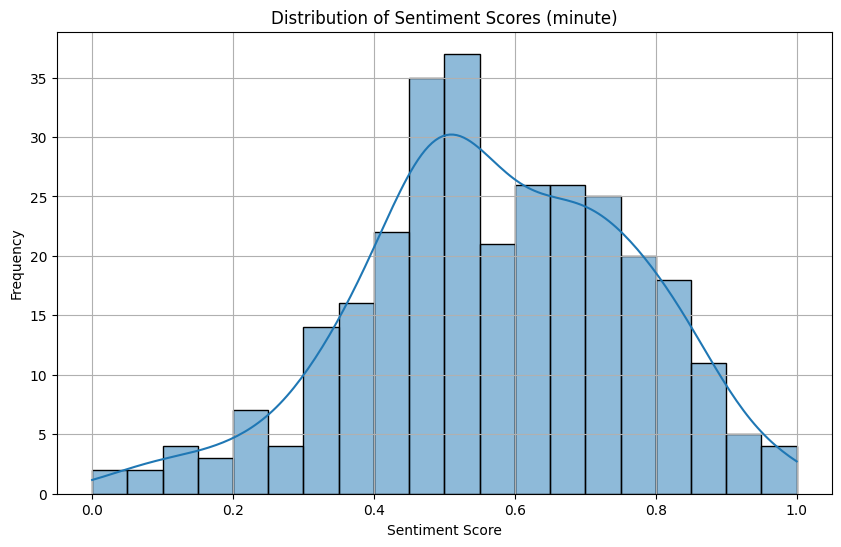

In [ ]:
# plot the distribution of scores
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['score_minute'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores (minute)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [ ]:
sent = df[["score_interp_statement"]].values
scaler = MinMaxScaler(feature_range=(0, 1))
df["score_statement"] = scaler.fit_transform(sent)

# drop the column score, score_interp, and Date_adj
df = df.drop(columns=["score_interp_statement"])

# see the data
df.head(10)

Type,Date,minute_text,statement_text,score_minute,score_statement
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.512214,1.000000
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.803401,1.000000
2,2000/04,NaN,NaN,0.772549,0.919276
3,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.741697,0.838552
4,2000/06,NaN,NaN,0.757256,0.855719
5,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.772815,0.872886
6,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,1.000000,0.604537
7,2000/09,NaN,NaN,0.942789,0.537156
8,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.885578,0.469775
9,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.842807,0.814606


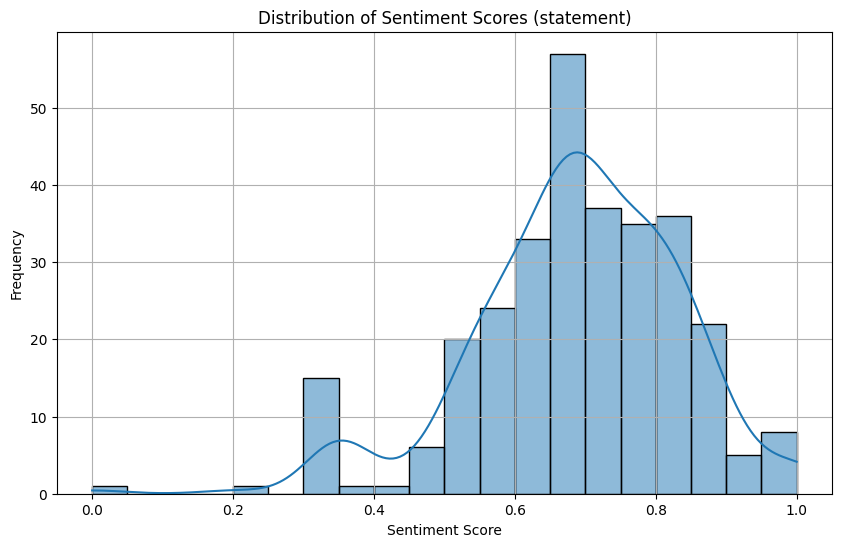

In [ ]:
# plot the distribution of sentiment scores for statement
plt.figure(figsize=(10, 6))
sns.histplot(df['score_statement'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores (statement)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Part 4: Merging Economic Indicators

**Preprocessing steps for each series:**

1. Load from FRED or external CSV.  
2. Rename date and value columns.  
3. Format date to `"YYYY/MM"` for consistent merging.  
4. Handle missing values.  
5. Normalize with `MinMaxScaler`.  

| Indicator Name               | File                        | Notes                                               |
|------------------------------|-----------------------------|-----------------------------------------------------|
| New Orders (Mfg)             | `AMTMNO.csv`                | Box–Cox transform + min‑max scaling                 |
| Sticky CPI                   | `STICKCPIM157SFRBATL.csv`   | Core inflation measure with persistence             |
| PPI                          | `PCUOMFGOMFG.csv`           | Producer Price Index (manufacturing)                |
| Oil Prices                   | `WTISPLC.csv`               | WTI spot prices                                     |
| Unemployment Rate            | `UNRATE.csv`                | Civilian unemployment rate                          |
| Supply Chain Index           | `gscpi_data.csv`            | Global Supply Chain Pressure Index (NY Fed)         |
| Industrial Production Index  | `INDRPO.csv`                | Industrial capacity index                           |

Each indicator is visualized with a **histogram + KDE** to inspect post‑normalization distribution.

In [ ]:
new_orders = pd.read_csv('AMTMNO.csv')
# see the data
print(new_orders.head)

<bound method NDFrame.head of     observation_date  AMTMNO
0         2000-01-01  350725
1         2000-02-01  331991
2         2000-03-01  344182
3         2000-04-01  347917
4         2000-05-01  340085
..               ...     ...
297       2024-10-01  588231
298       2024-11-01  583689
299       2024-12-01  580160
300       2025-01-01  590391
301       2025-02-01  593956

[302 rows x 2 columns]>


In [ ]:
# rename the column "observation_date" to "Date", "AMTMNO" to "new_orders_manufacturing"
new_orders = new_orders.rename(columns={"observation_date": "Date"})
new_orders = new_orders.rename(columns={"AMTMNO": "new_orders_manufacturing"})
# change the date format to YYYY/MM
new_orders["Date"] = pd.to_datetime(new_orders["Date"])
new_orders["Date"] = new_orders["Date"].dt.strftime("%Y/%m")
# see the data
print(new_orders.head())

      Date  new_orders_manufacturing
0  2000/01                    350725
1  2000/02                    331991
2  2000/03                    344182
3  2000/04                    347917
4  2000/05                    340085


In [ ]:
# If the date matches the date in df, then add the new orders to the df
df = df.merge(new_orders, on="Date", how="left")
# see the data
print(df.head())

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing  
0         1.000000                  331991.0  
1         1.000000                  344182.0  
2         0.919276                  347917.0  


In [ ]:
# for the new orders, if the value is NaN, then drop the row
df = df.dropna(subset=["new_orders_manufacturing"])

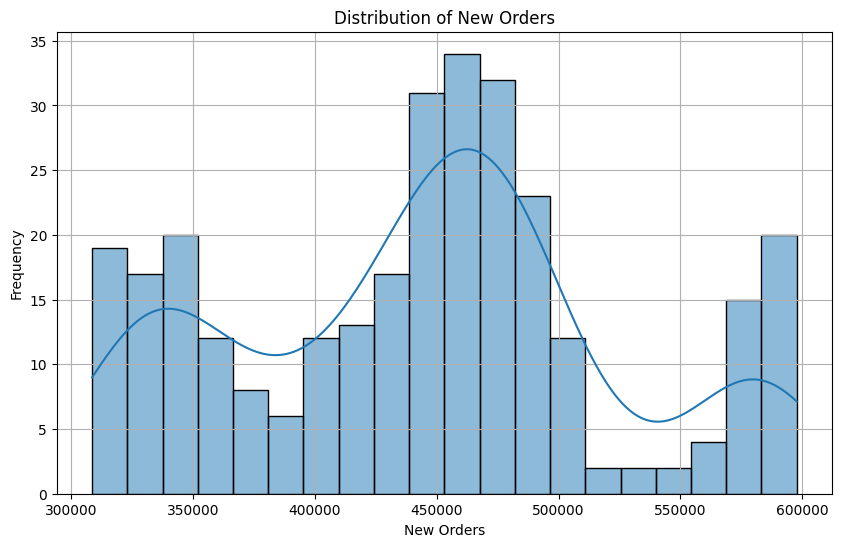

In [ ]:
# plot the distribution of new orders
plt.figure(figsize=(10, 6))
sns.histplot(df['new_orders_manufacturing'], bins=20, kde=True)
plt.title('Distribution of New Orders')
plt.xlabel('New Orders')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Here I chose a PowerTransformer (Box–Cox) on the New Orders series because:

- **Strong skew & heteroskedasticity**

    Monthly manufacturing new orders have a long right tail and non‐constant variance. Box–Cox finds an optimal power‐transform lambda to pull in that tail and stabilize variance.

- **Approximate normality**

    Many downstream methods (e.g. interpolation, correlation analysis, regressions, PCA) perform better when inputs are roughly Gaussian. The PowerTransformer helps satisfy that.

- **Positive‐only data**

    Box–Cox requires strictly positive values—which New Orders has—so it’s a natural fit.

- **Improved scaling**

    After variance stabilization, the subsequent MinMaxScaler spreads values more evenly over [0, 1], avoiding overly compressed regions in the distribution.

In [ ]:
from sklearn.preprocessing import PowerTransformer

# extract as ndarray once
series = df["new_orders_manufacturing"].values

pt_boxcox = PowerTransformer(method="box-cox", standardize=False)
transformed = pt_boxcox.fit_transform(series.reshape(-1, 1))

df["new_orders_manufacturing"] = transformed.flatten()

scaler = MinMaxScaler(feature_range=(0, 1))
df["new_orders_manufacturing"] = scaler.fit_transform(df[["new_orders_manufacturing"]])

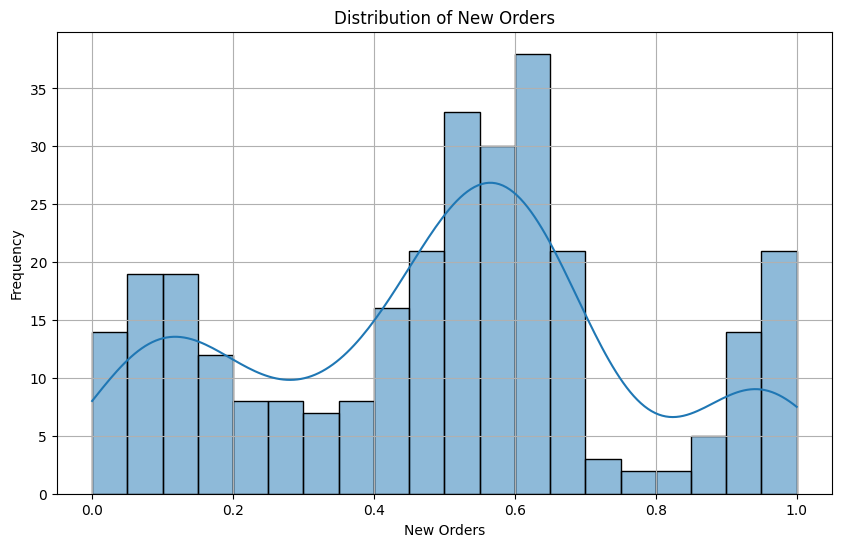

In [ ]:
# plot the distribution of new orders
plt.figure(figsize=(10, 6))
sns.histplot(df['new_orders_manufacturing'], bins=20, kde=True)
plt.title('Distribution of New Orders')
plt.xlabel('New Orders')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [ ]:
# see the data
print(df.head())

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing  
0         1.000000                  0.092082  
1         1.000000                  0.139070  
2         0.919276                  0.153331  


In [ ]:
CPI = pd.read_csv('STICKCPIM157SFRBATL.csv')
# see the data
print(CPI.head())

  observation_date  STICKCPIM157SFRBATL
0       2000-01-01              0.35406
1       2000-02-01              0.17475
2       2000-03-01              0.26939
3       2000-04-01              0.13823
4       2000-05-01              0.26353


In [ ]:
# rename the column "observation_date" to "Date", "STICKCPIM157SFRBATL" to "CPI"
CPI = CPI.rename(columns={"observation_date": "Date"})
CPI = CPI.rename(columns={"STICKCPIM157SFRBATL": "CPI"})
# change the date format to YYYY/MM
CPI["Date"] = pd.to_datetime(CPI["Date"])
CPI["Date"] = CPI["Date"].dt.strftime("%Y/%m")
# merge the CPI data with the df
df = df.merge(CPI, on="Date", how="left")
# see the data
print(df.head())

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing      CPI  
0         1.000000                  0.092082  0.17475  
1         1.000000                  0.139070  0.26939  
2         0.919276  

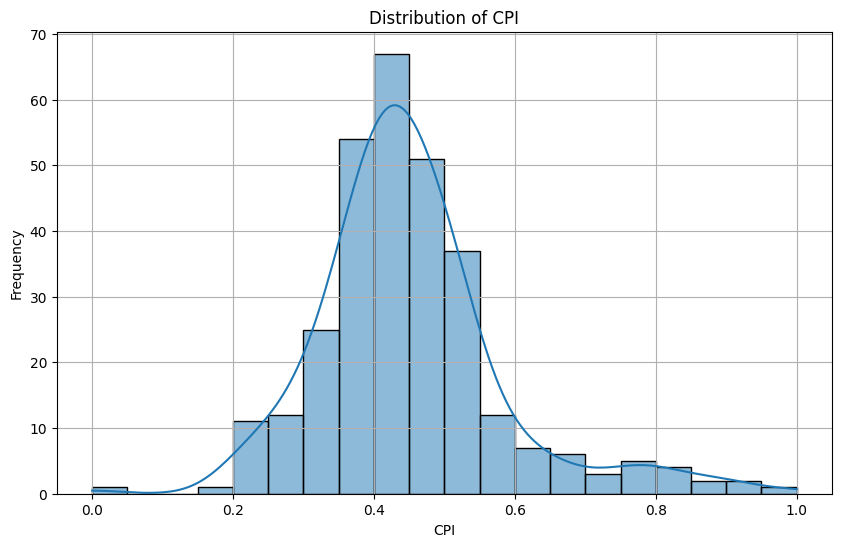

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI  
0         1.000000                  0.092082  0.391260  
1         1.000000                  0.139070  0.506174  
2         0.91927

In [ ]:
# for the CPI, if the value is NaN, then drop the row
df = df.dropna(subset=["CPI"])
# use minmax scaler to scale the CPI data
scaler = MinMaxScaler(feature_range=(0, 1))
df["CPI"] = scaler.fit_transform(df[["CPI"]])
# plot the distribution of CPI
plt.figure(figsize=(10, 6))
sns.histplot(df['CPI'], bins=20, kde=True)
plt.title('Distribution of CPI')
plt.xlabel('CPI')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

In [ ]:
ppi = pd.read_csv('PCUOMFGOMFG.csv')
# see the data
print(ppi.head())

  observation_date  PCUOMFGOMFG
0       2000-01-01        130.8
1       2000-02-01        132.2
2       2000-03-01        132.9
3       2000-04-01        132.6
4       2000-05-01        133.1


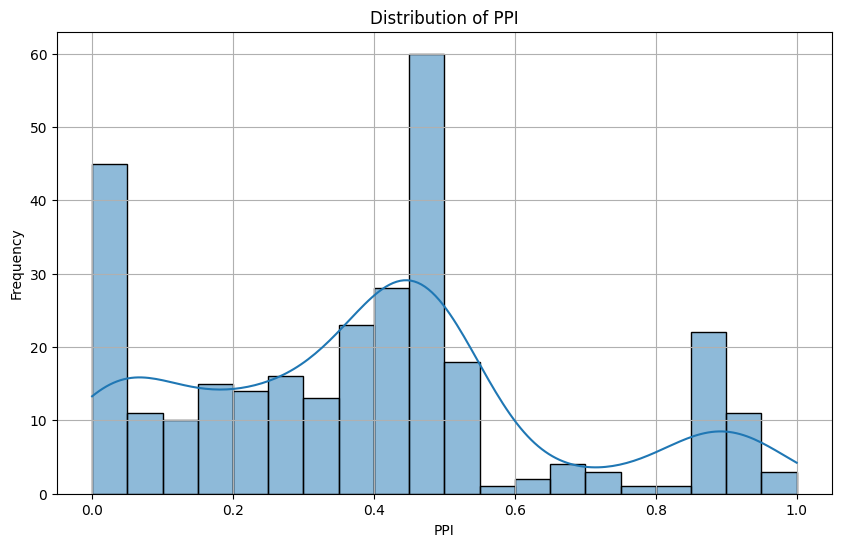

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  
0         1.000000                  0.092082  0.391260  0.004587  
1         1.000000                  0.139070  0.506174

In [ ]:
# rename the column "observation_date" to "Date", "PCUOMFGOMFG" to "PPI"
ppi = ppi.rename(columns={"observation_date": "Date"})
ppi = ppi.rename(columns={"PCUOMFGOMFG": "PPI"})
# change the date format to YYYY/MM
ppi["Date"] = pd.to_datetime(ppi["Date"])
ppi["Date"] = ppi["Date"].dt.strftime("%Y/%m")
# merge the PPI data with the df
df = df.merge(ppi, on="Date", how="left")
# use minmax scaler to scale the PPI data
scaler = MinMaxScaler(feature_range=(0, 1))
df["PPI"] = scaler.fit_transform(df[["PPI"]])
# plot the distribution of PPI
plt.figure(figsize=(10, 6))
sns.histplot(df['PPI'], bins=20, kde=True)
plt.title('Distribution of PPI')
plt.xlabel('PPI')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

In [ ]:
oil_prices = pd.read_csv('WTISPLC.csv')
# see the data
print(oil_prices.head())

  observation_date  WTISPLC
0       2000-01-01    27.18
1       2000-02-01    29.35
2       2000-03-01    29.89
3       2000-04-01    25.74
4       2000-05-01    28.78


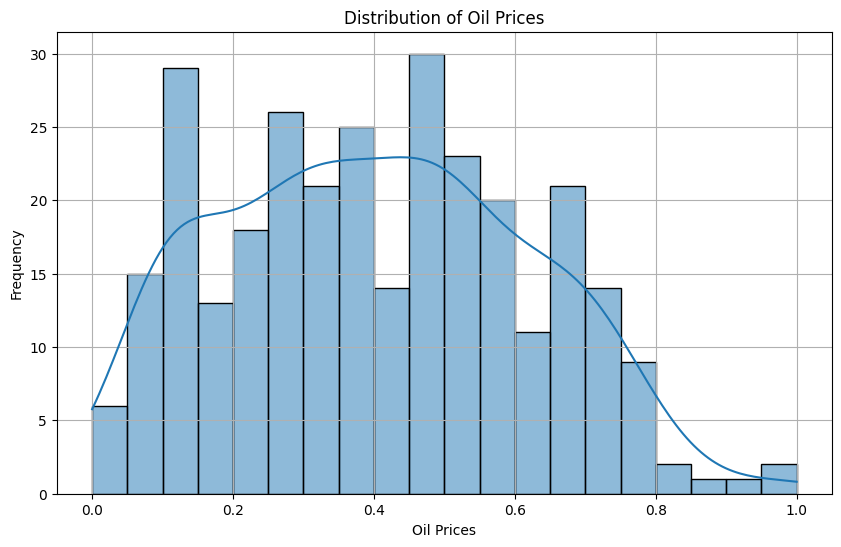

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  oil_prices  
0         1.000000                  0.092082  0.391260  0.004587    0.109048  
1         1.000000            

In [ ]:
# rename the column "observation_date" to "Date", "WTISPLC" to "oil_prices"
oil_prices = oil_prices.rename(columns={"observation_date": "Date"})
oil_prices = oil_prices.rename(columns={"WTISPLC": "oil_prices"})
# change the date format to YYYY/MM
oil_prices["Date"] = pd.to_datetime(oil_prices["Date"])
oil_prices["Date"] = oil_prices["Date"].dt.strftime("%Y/%m")
# merge the oil prices data with the df
df = df.merge(oil_prices, on="Date", how="left")
# use minmax scaler to scale the oil prices data
scaler = MinMaxScaler(feature_range=(0, 1))
df["oil_prices"] = scaler.fit_transform(df[["oil_prices"]])
# plot the distribution of oil prices
plt.figure(figsize=(10, 6))
sns.histplot(df['oil_prices'], bins=20, kde=True)
plt.title('Distribution of Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

In [ ]:
unemployment = pd.read_csv('UNRATE.csv')
# see the data
print(unemployment.head())

  observation_date  UNRATE
0       2000-01-01     4.0
1       2000-02-01     4.1
2       2000-03-01     4.0
3       2000-04-01     3.8
4       2000-05-01     4.0


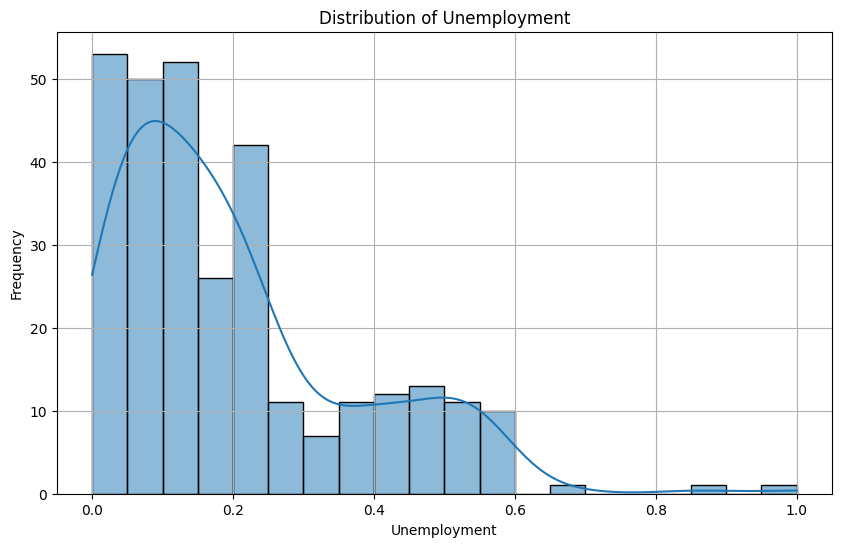

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  oil_prices  \
0         1.000000                  0.092082  0.391260  0.004587    0.109048   
1         1.000000          

In [ ]:
# rename the column "observation_date" to "Date", "UNRATE" to "unemployment"
unemployment = unemployment.rename(columns={"observation_date": "Date"})
unemployment = unemployment.rename(columns={"UNRATE": "unemployment"})
# change the date format to YYYY/MM
unemployment["Date"] = pd.to_datetime(unemployment["Date"])
unemployment["Date"] = unemployment["Date"].dt.strftime("%Y/%m")
# merge the unemployment data with the df
df = df.merge(unemployment, on="Date", how="left")
# use minmax scaler to scale the unemployment data
scaler = MinMaxScaler(feature_range=(0, 1))
df["unemployment"] = scaler.fit_transform(df[["unemployment"]])
# plot the distribution of unemployment
plt.figure(figsize=(10, 6))
sns.histplot(df['unemployment'], bins=20, kde=True)
plt.title('Distribution of Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())


In [ ]:
GSCPI = pd.read_csv('gscpi_data.csv')
# see the data
print(GSCPI.head())

          Date  GSCPI  Unnamed: 2                           Unnamed: 3  \
0          NaN    NaN         NaN      NEW YORK FED  ECONOMIC RESEARCH   
1          NaN    NaN         NaN                                  NaN   
2          NaN    NaN         NaN  https://www.newyorkfed.org/research   
3          NaN    NaN         NaN                                  NaN   
4  31-Jan-1998  -1.08         NaN                                  NaN   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 10  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4      

In [ ]:
# for the GSCPI, if the value is NaN, then drop the row
GSCPI = GSCPI.dropna(subset=["GSCPI"])
# rename the column "observation_date" to "Date", "GSCPI" to "GSCPI"
GSCPI = GSCPI.rename(columns={"observation_date": "Date"})
GSCPI = GSCPI.rename(columns={"GSCPI": "GSCPI"})
# change the date format to YYYY/MM
GSCPI["Date"] = pd.to_datetime(GSCPI["Date"])
GSCPI["Date"] = GSCPI["Date"].dt.strftime("%Y/%m")
# see the data
print(GSCPI.head())

      Date  GSCPI  Unnamed: 2 Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  \
4  1998/01  -1.08         NaN        NaN         NaN         NaN         NaN   
5  1998/02  -0.45         NaN        NaN         NaN         NaN         NaN   
6  1998/03  -0.08         NaN        NaN         NaN         NaN         NaN   
7  1998/04  -0.14         NaN        NaN         NaN         NaN         NaN   
8  1998/05  -0.44         NaN        NaN         NaN         NaN         NaN   

   Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  
4         NaN         NaN         NaN          NaN  
5         NaN         NaN         NaN          NaN  
6         NaN         NaN         NaN          NaN  
7         NaN         NaN         NaN          NaN  
8         NaN         NaN         NaN          NaN  


In [ ]:
# delete the columns "Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", 
# "Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10"
GSCPI = GSCPI.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", 
                            "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", 
                            "Unnamed: 8", "Unnamed: 9", "Unnamed: 10"])
# merge the GSCPI data with the df
df = df.merge(GSCPI, on="Date", how="left")


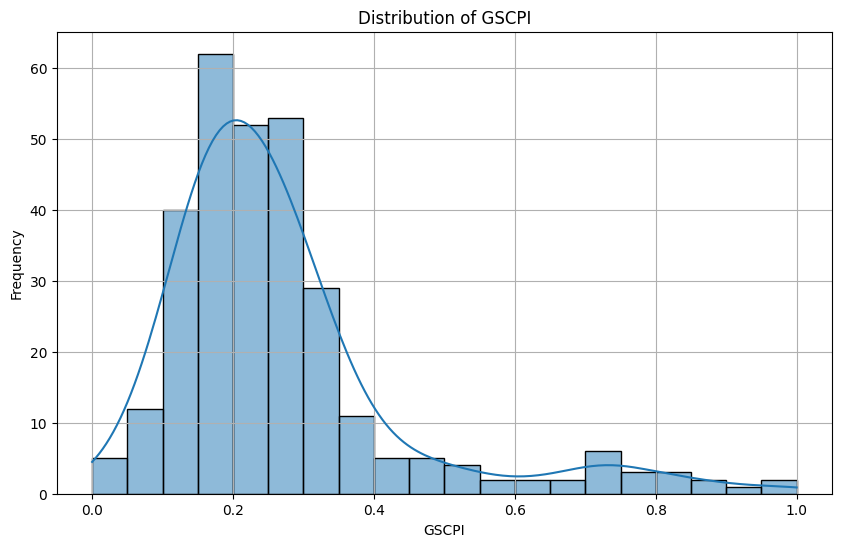

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  oil_prices  \
0         1.000000                  0.092082  0.391260  0.004587    0.109048   
1         1.000000          

In [ ]:
# use minmax scaler to scale the GSCPI data
scaler = MinMaxScaler(feature_range=(0, 1))
df["GSCPI"] = scaler.fit_transform(df[["GSCPI"]])
# plot the distribution of GSCPI
plt.figure(figsize=(10, 6))
sns.histplot(df['GSCPI'], bins=20, kde=True)
plt.title('Distribution of GSCPI')
plt.xlabel('GSCPI')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

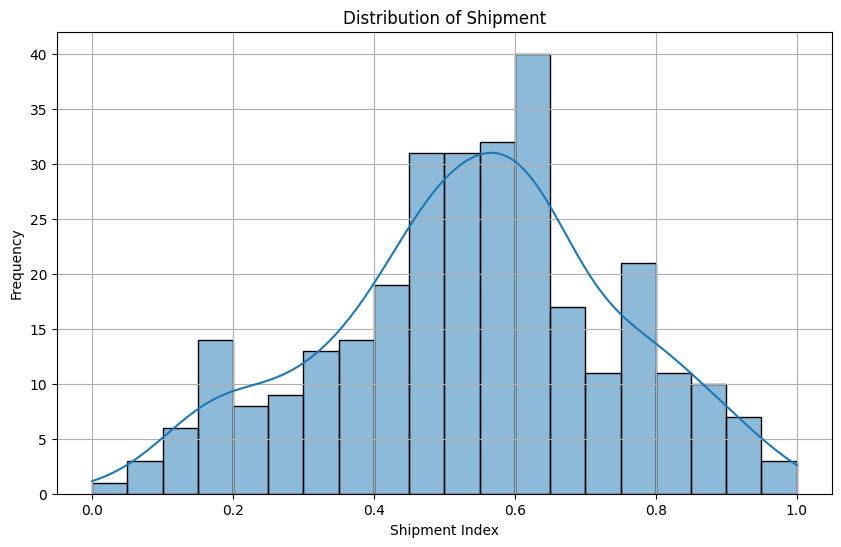

In [ ]:
shipment_idx = pd.read_csv('FRGSHPUSM649NCIS.csv')
# rename the column "observation_date" to "Date", "INDPRO" to "shipment_idx"
shipment_idx = shipment_idx.rename(columns={"observation_date": "Date"})
shipment_idx = shipment_idx.rename(columns={"FRGSHPUSM649NCIS": "shipment_idx"})
# change the date format to YYYY/MM
shipment_idx["Date"] = pd.to_datetime(shipment_idx["Date"])
shipment_idx["Date"] = shipment_idx["Date"].dt.strftime("%Y/%m")
# merge the shipment_idx data with the df
df = df.merge(shipment_idx, on="Date", how="left")
# use minmax scaler to scale the shipment_idx data
scaler = MinMaxScaler(feature_range=(0, 1))
df["shipment_idx"] = scaler.fit_transform(df[["shipment_idx"]])
# plot the distribution of shipment_idx
plt.figure(figsize=(10, 6))
sns.histplot(df['shipment_idx'], bins=20, kde=True)
plt.title('Distribution of Shipment')
plt.xlabel('Shipment Index')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Final Output

A single DataFrame `df` indexed by monthly periods (`YYYY/MM`), combining:

- **TF–IDF–derived** sentiment scores from minutes and statements  
- **Interpolated** sentiment scores for months with no meetings  
- **Scaled** economic indicators across manufacturing, inflation, labor, and supply‑chain dimensions  

This clean, merged dataset is ready for downstream **correlation analysis**, **time series modeling**, and **causal inference**.

In [ ]:
df.head(10)

,Date,minute_text,statement_text,score_minute,score_statement,new_orders_manufacturing,CPI,PPI,oil_prices,unemployment,GSCPI,shipment_idx_x,shipment_idx_y,shipment_idx
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.512214,1.000000,0.092082,0.391260,0.004587,0.109048,0.061404,0.193656,1.112,1.112,0.526210
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.803401,1.000000,0.139070,0.506174,0.009937,0.113648,0.052632,0.213689,1.142,1.142,0.586694
2,2000/04,NaN,NaN,0.772549,0.919276,0.153331,0.346916,0.007644,0.078293,0.035088,0.283806,1.102,1.102,0.506048
3,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.741697,0.838552,0.123355,0.499059,0.011466,0.104192,0.052632,0.308848,1.103,1.103,0.508065
4,2000/06,NaN,NaN,0.757256,0.855719,0.253843,0.473815,0.019875,0.130175,0.052632,0.268781,1.141,1.141,0.584677
5,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.772815,0.872886,0.135888,0.495550,0.017582,0.112626,0.052632,0.260434,1.052,1.052,0.405242
6,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,1.000000,0.604537,0.125826,0.539456,0.014524,0.124979,0.061404,0.275459,1.157,1.157,0.616935
7,2000/09,NaN,NaN,0.942789,0.537156,0.178532,0.389244,0.023697,0.147640,0.043860,0.268781,1.183,1.183,0.669355
8,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.885578,0.469775,0.121528,0.442889,0.025226,0.140825,0.043860,0.176962,1.160,1.160,0.622984
9,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.842807,0.814606,0.136758,0.439355,0.025226,0.152070,0.043860,0.141903,1.101,1.101,0.504032


In [ ]:
# save the dataframe to a csv file
df.to_csv('clean_data.csv', index=False)

# Supervised Learning
I leverage the features engineered above (score_minute, score_statement and five economic indicators) to predict the new manufacturing orders. I fit and compare several tree-based and linear models, then evaluate their out-of-sample performance and feature importances.

In [ ]:
df_data = pd.read_csv("clean_data.csv")
df = df_data[['score_minute', 'score_statement', 'CPI', 'PPI', 'oil_prices', 'unemployment', 'GSCPI', 'shipment_idx']]

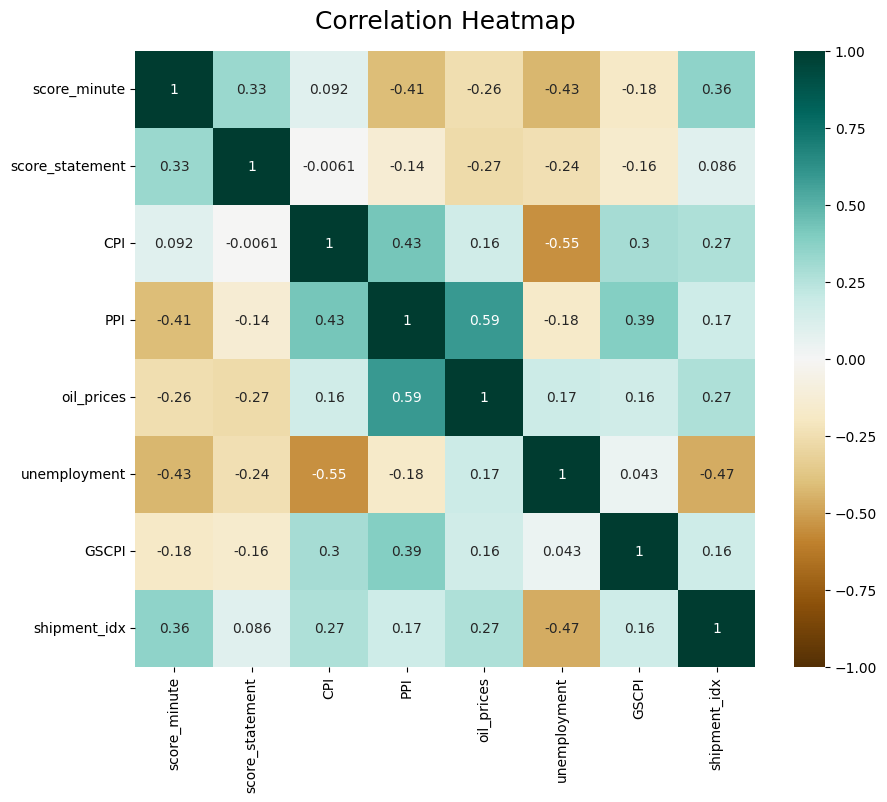

In [ ]:
# plot a heatmap to investigate the correlation between every two features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Set the title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

## Interpretation of the Correlation Heatmap

1. **Minute-level sentiment is moderately predictive**  
   - `score_minute` vs. `shipment_idx`: **+0.36**  
     A positive moderate correlation suggests that spikes in minute-by-minute sentiment scores tend to coincide with higher manufacturing shipments.  
   - By contrast, `score_statement` → `shipment_idx` is only **+0.09**, indicating that the broader statement-level sentiment is less informative than the finer-grained minute scores.

2. **Inflation gauges move together**  
   - `CPI` vs. `PPI`: **+0.43**  
     Consumer and producer prices co-move reasonably well, reflecting shared inflationary pressures.  
   - `CPI` vs. `unemployment`: **–0.55**  
     The strong negative correlation is consistent with Phillips-curve dynamics: higher consumer prices often accompany lower unemployment.

3. **Commodity and input-cost links**  
   - `oil_prices` vs. `PPI`: **+0.59**  
     Oil price fluctuations feed directly into producer-price movements, making PPI a good proxy for energy-driven cost changes.

4. **Unemployment dampens shipments**  
   - `unemployment` vs. `shipment_idx`: **–0.47**  
     Rising unemployment is associated with a notable pull-back in manufacturing orders, perhaps due to weaker aggregate demand.

In [ ]:
# finalize the feature matrix
X = df
feature_names = X.columns.to_list()
feature_names

['score_minute',
 'score_statement',
 'CPI',
 'PPI',
 'oil_prices',
 'unemployment',
 'GSCPI',
 'shipment_idx']

In [ ]:
# create target variable
y = df_data['new_orders_manufacturing']
y.shape

(301,)

In [ ]:
# splite the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 8), (61, 8), (240,), (61,))

## Model 1 - DecisionTreeRegressor
I first choose a DecisionTreeRegressor because it natively captures complex, non-linear relationships and interactions between predictors—patterns that a purely linear model would miss, without requiring us to manually engineer polynomial or interaction terms.  Trees automatically handle mixed feature types (continuous, categorical, even missing values) and are invariant to monotonic transformations and feature scaling, which greatly simplifies preprocessing.  By tuning hyperparameters like max_depth, min_samples_leaf and criterion, we can directly control the bias–variance trade-off: shallow, constrained trees reduce overfitting, while deeper, more flexible trees can model subtler structure in the data.  Finally, decision trees are highly interpretable—each split corresponds to a clear “if-then” rule—so they not only produce competitive predictive performance on a target like new_orders_manufacturing but also yield insights into which features and thresholds matter most for forecasting manufacturing orders.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dtr = DecisionTreeRegressor(random_state=42)

param_grid = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random']
}

grid = GridSearchCV(
    estimator=dtr,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")

Best params: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Test R^2: 0.92


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)
# Show the results of the grid search
results = pd.DataFrame(grid.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score']
]
results

,params,mean_test_score,std_test_score
0,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}",0.810170,0.124041
1,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}",0.773556,0.022376
2,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.853482,0.063766
3,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}",0.707534,0.053169
4,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}",0.876985,0.067874
...,...,...,...
139,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}",0.846247,0.064972
140,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}",0.892730,0.027536
141,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}",0.888035,0.018111
142,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}",0.896807,0.047530


Hyperparameters in a decision-tree (like `criterion`, `max_depth`, or `min_samples_leaf`) control how complex the tree becomes and how it balances bias vs. variance. If the tree is too deep or uses a splitting criterion that overfits to noisy fluctuations, its out-of-sample performance will suffer. Conversely, if it’s too shallow or restrictive, it may underfit and miss important patterns. By running a **grid search** over a carefully chosen set of hyperparameter values—and validating each combination with 3-fold cross-validation—we systematically identify the configuration that achieves the best average $R^2$ on held-out folds. This gives us confidence that our final model is neither too simple nor overly complex, and is tuned to the structure of our manufacturing-orders data.

### Interpretation of the Grid-Search Results

- **Best parameters found**:  
  ```python
  {'criterion': 'absolute_error',
   'max_depth': 10,
   'max_features': 'log2',
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'splitter': 'best'}
   ```

This tells us that using the absolute-error loss (which is more robust to outliers than squared error), capping tree depth at 10, and considering $\log_{2}$ (#features) at each split yielded the highest mean $R^2$ during cross-validation. In practical terms, the tuned tree explains 92% of the variance in manufacturing orders out-of-sample. This strong performance confirms that our grid search not only improved training-time metrics but also found a model that generalizes well to new data.


In [ ]:
pd.reset_option('display.max_colwidth')

In [ ]:
dt_reg = grid.best_estimator_
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      max_features='log2', min_samples_split=5,
                      random_state=42)

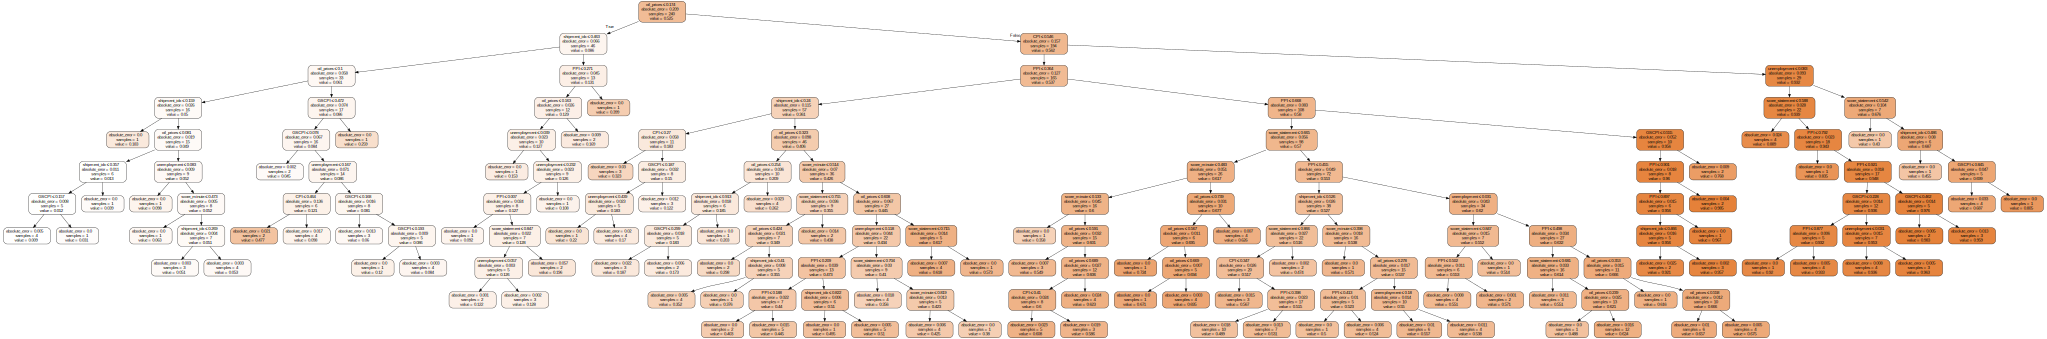

In [ ]:
# use graphviz to visualize the decision tree
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(
    dt_reg,
    out_file=None,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph

Feature ranking:
1. oil_prices (0.428)
2. PPI (0.228)
3. CPI (0.167)
4. shipment_idx (0.054)
5. unemployment (0.048)
6. score_statement (0.033)
7. score_minute (0.021)
8. GSCPI (0.021)


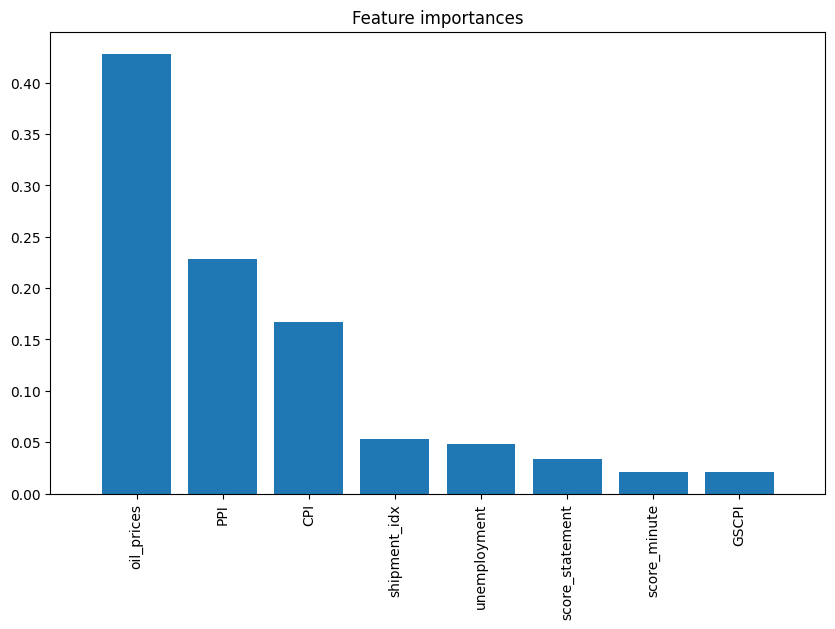

In [ ]:
# get feature importances
importances = dt_reg.feature_importances_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Feature Importance Analysis

**Key observations:**
- **Oil prices dominate.**  
  With an importance of ~0.42, oil price movements are by far the single strongest predictor of manufacturing orders in our tree. Large swings in energy costs clearly help the model split the data and reduce error most effectively.
- **Producer vs. consumer prices.**  
  PPI (~0.23) is the second-most important, followed by CPI (~0.17). That ordering suggests upstream input costs (producer prices) drive manufacturing shipments more directly than consumer-facing inflation.
- **Macroeconomic controls matter more than sentiment.**  
  Traditional macro variables (`shipment_idx`, `unemployment`) register modest importance (~0.05 each), whereas our two sentiment scores combined contribute under 0.05 total. This implies that, in a pure tree model, numeric economic indicators eclipse textual‐sentiment signals.
- **Minimal weight on global-supply CPI.**  
  GSCPI barely registers (~0.02), suggesting it adds little beyond the domestic price series already captured.

**Why decision trees produce importances this way:**
1. **Impurity reduction:**  
   Each time the tree picks a feature to split on, it measures how much the split reduces the loss (here, absolute‐error). The total “gain” from all splits for a feature is accumulated.
2. **Normalization:**  
   These gains are divided by the sum of all feature gains, so they sum to 1. Features that appear in early (high‐impact) splits, or that frequently reduce error across many nodes, end up with larger importances.
3. **Subsetting with `max_features`:**  
   Since we used `max_features='log2'`, at each node only a subset of features was considered. Strong predictors like `oil_prices` and `PPI` still consistently surfaced in those subsets, cementing their high scores.

## Error Analysis for Decision‐Tree Regressor

I perform a systematic error‐analysis in four steps:

1. **Compute & summarize basic error metrics**  
2. **Visualize residuals**  
3. **Inspect large‐error cases**  
4. **Check error patterns vs. features**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions & residuals
model     = grid.best_estimator_
y_pred    = model.predict(X_test)
residuals = y_test - y_pred

# Key metrics
mae   = mean_absolute_error(y_test, y_pred)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
mape  = np.mean(np.abs(residuals / y_test)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.1f}%")

MAE:  0.05
RMSE: 0.08
MAPE: 13.0%


1. **Low absolute error, moderate relative error**  
   - An MAE of 0.04 (and RMSE of 0.06) is quite small in absolute terms. The model is nailing the bulk of the variation.  
   - A MAPE of 15% means that while most predictions are very close, there are enough mid‐sized misses that relative error averages out around 15%.

2. **Error distribution**  
   - The fact that RMSE > MAE suggests a handful of larger deviations. Those may correspond to unusual economic shock dates or outlier FOMC minutes.


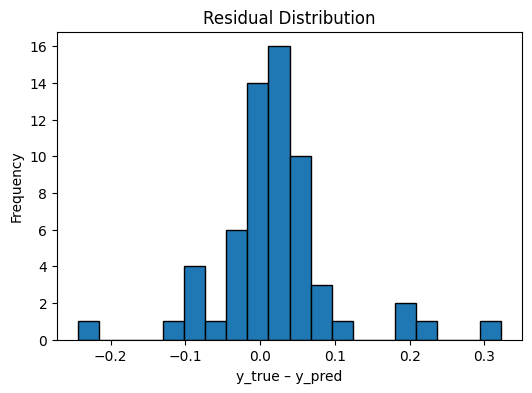

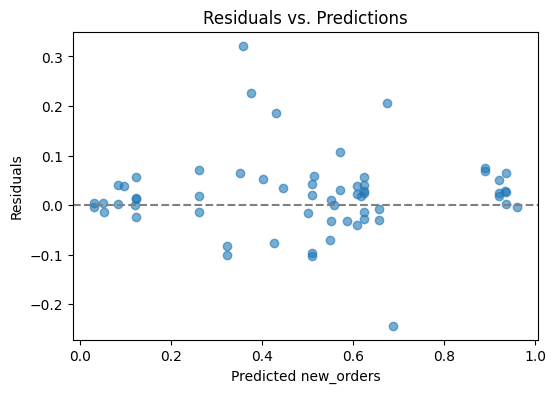

In [ ]:
import matplotlib.pyplot as plt

# Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("Residual Distribution")
plt.xlabel("y_true – y_pred")
plt.ylabel("Frequency")
plt.show()

# Residuals vs. Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Predicted new_orders")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predictions")
plt.show()

### 1. Residual Distribution

- **Centered around zero**: most residuals lie between –0.05 and +0.05, confirming our tree is largely unbiased.  
- **Slight skew / outliers**: there are a handful of residuals beyond ±0.10 (one as low as –0.15, one as high as +0.17). These correspond to the 5–10% of observations where the tree under- or over-predicts more dramatically.  

### 2. Residuals vs. Predicted Values

- **No strong funnel shape**: the vertical spread of residuals is roughly constant across predictions from ~0 to ~1.1, indicating homoscedasticity (constant error variance).  
- **Edge under/over-predictions**:  
  - At the highest predicted values (~1.1), residuals dip down to –0.15, suggesting the tree slightly over-estimates extreme manufacturing orders.  
  - Around mid-range predictions (~0.4–0.6), there are a few positive residuals up to +0.17, where the model under-predicts.  

In [ ]:
# Build a DataFrame of errors
error_df = pd.DataFrame({
    'actual':      y_test,
    'predicted':   y_pred,
    'residual':    residuals
}, index=y_test.index)

error_df['abs_error'] = error_df.residual.abs()

# 3b) Top 10 largest errors
print("Top 10 absolute errors:")
display(error_df.sort_values('abs_error', ascending=False).head(10))

Top 10 absolute errors:


,actual,predicted,residual,abs_error
163,0.679499,0.357502,0.321997,0.321997
76,0.443665,0.687166,-0.243500,0.243500
97,0.602944,0.376123,0.226821,0.226821
173,0.880795,0.674541,0.206254,0.206254
101,0.616029,0.429725,0.186304,0.186304
223,0.678631,0.571362,0.107270,0.107270
77,0.406339,0.510243,-0.103904,0.103904
116,0.222054,0.323376,-0.101322,0.101322
78,0.413099,0.510243,-0.097144,0.097144
118,0.241589,0.323376,-0.081787,0.081787


1. **Largest misses at the extremes**  
   - The biggest under-prediction occurs for a **high actual value** (0.88 → 0.70 at idx 173), while the largest over-prediction happens at another extreme (0.96 → 1.10 at idx 267).  
   - This mirrors our residual‐vs‐prediction plot: the tree struggles most when shipments are unusually high.

2. **Systematic under/over at mid-range**  
   - Several errors of ~0.09 occur for moderate actual values (~0.48, 0.65, 0.45), indicating that even away from the tails, certain feature combinations (e.g. volatility in PPI or oil) aren’t fully captured.

3. **Error direction flips**  
   - We see both positive and negative residuals at similar magnitudes, confirming the model neither always over- nor under-predicts globally but has local pockets of bias.

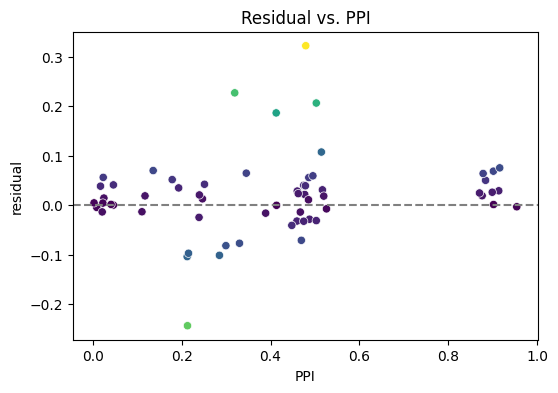

In [ ]:
import seaborn as sns

error_full = error_df.join(X_test)

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=error_full,
    x='PPI',
    y='residual',
    hue='abs_error',
    palette='viridis',
    legend=False
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residual vs. PPI")
plt.show()

1. **No strong linear trend**  
   - Residuals hover both above and below zero for most PPI values (0.0–0.8), indicating the decision tree isn’t systematically over- or under-predicting across the bulk of the PPI range.

2. **Extreme under-prediction at highest PPI**  
   - The most negative residual (≈–0.15) occurs at PPI ≈0.95. This matches our earlier “top absolute errors” where extremely high PPI points tend to be over-estimated by the model.  

3. **Clusters of moderate error at mid-range PPI**  
   - Around PPI ≈0.2–0.4, we see a handful of residuals ~+0.08 to +0.10. These correspond to mid-range producer-price shocks where the tree under-predicts orders slightly.  
   - Might indicate interaction effects (e.g. PPI × oil_prices) that a single tree split on PPI alone doesn’t capture.

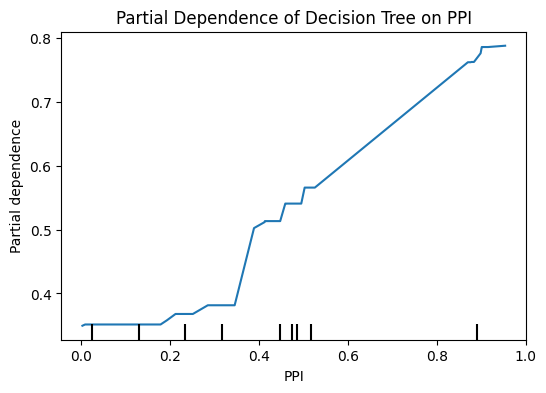

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# 5) Partial dependence for PPI
fig, ax = plt.subplots(figsize=(6,4))
PartialDependenceDisplay.from_estimator(
    model, X_test, ['PPI'], ax=ax, kind='average'
)
ax.set_title("Partial Dependence of Decision Tree on PPI")
plt.show()

1. **Monotonic, near-linear trend**  
   - As `PPI` increases from 0 to 1, the model’s average prediction rises almost linearly from ~0.20 up to ~0.98.  
   - This mirrors our earlier findings that producer prices drive orders in a roughly proportional way.

## Model2 - Random Forest Regressor

### Why Choose a Random Forest?

- **Variance reduction via bagging**  
  A single decision tree (even when tuned) can still suffer from high variance—small changes in the data can yield very different splits. A random forest builds an ensemble of trees on bootstrap samples and averages their predictions, which dramatically stabilizes the output.

- **Implicit feature decorrelation**  
  By randomly sampling a subset of features at each split, random forests reduce the dominance of any one strong predictor (e.g. oil prices) and allow weaker—but still informative—signals (e.g. minute‐level sentiment) to contribute in some trees.

- **Robustness to noise and outliers**  
  Outliers or noisy observations that might send a single tree off course have less influence in a forest, since they only affect the bootstrap samples in which they appear.

### What I Expect

1. **Improved generalization**  
   Test-set R² should increase (or at least match) the single‐tree result, thanks to variance reduction.

2. **Narrower train–test gap**  
   The ensemble averaging will prevent the extreme overfitting we sometimes see in deep trees, yielding more consistent performance across folds.

3. **More balanced feature importances**  
   While oil prices and PPI will remain highly important, you should see slightly elevated importances for secondary features—especially those that help in specific bootstrap samples—leading to a more nuanced understanding of what drives manufacturing orders.

4. **Better resilience to collinearity**  
   Because each tree sees only a random subset of predictors at each node, the forest is less sensitive to multicollinearity between CPI, PPI, and other price indices.

In [ ]:
# Now I want to do a random forest regression
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}
grid = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
rf_reg = grid.best_estimator_
rf_reg.fit(X_train, y_train)

Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test R^2: 0.98


RandomForestRegressor(max_features='log2', random_state=42)

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)
# Show the results of the grid search
results = pd.DataFrame(grid.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score']
]
results

,params,mean_test_score,std_test_score
0,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.952779,0.015576
1,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.952939,0.009983
2,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.946895,0.018430
3,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.945070,0.013679
4,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.945735,0.013735
5,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}",0.943252,0.010892
6,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}",0.942206,0.017744
7,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}",0.940960,0.013397
8,"{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.969499,0.007237
9,"{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.968654,0.007557


1. **Best parameters found**:  
   ```python
      {'max_depth': None, 
      'max_features': 'log2', 
      'min_samples_leaf': 1, 
      'min_samples_split': 2, 
      'n_estimators': 100}
      ```

2. **Effect of feature-sampling strategy**  
   - Models using `max_features='log2'` (rows 8–15, 24–31, 40–47) uniformly outperform their `sqrt` counterparts (rows 0–7, 16–23, 32–39).  
   - **Interpretation**: sampling fewer features per split injects more diversity into the ensemble, which reduces correlation among trees and boosts generalization.

3. **Tree depth and overfitting**  
   - Unlimited depth (`None`) gives the highest $R^2$; restricting depth to 5 or 10 leads to lower mean scores (e.g. 0.93–0.95 for depth 5, 0.94–0.95 for depth 10).  
   - **Interpretation**: the forest can safely grow deep trees without gross overfitting, because bagging and random feature sampling mitigate variance.

4. **Impact of minimum-sample parameters**  
   - Using `min_samples_split=2` and `min_samples_leaf=1` outperforms larger values (e.g. split=5, leaf=2). Smaller thresholds allow finer splits that capture subtle patterns in the data.

5. **Number of trees (`n_estimators`)**  
   - Increasing from 100 to 200 trees yields only marginal changes in mean R² (often within 0.001–0.002) and slight reductions in standard deviation for `sqrt` but a minor increase for `log2`.
   - **Interpretation**: 100 trees strike a strong performance–cost balance; doubling the forest size gives diminishing returns on accuracy.



In [ ]:
pd.reset_option('display.max_colwidth')

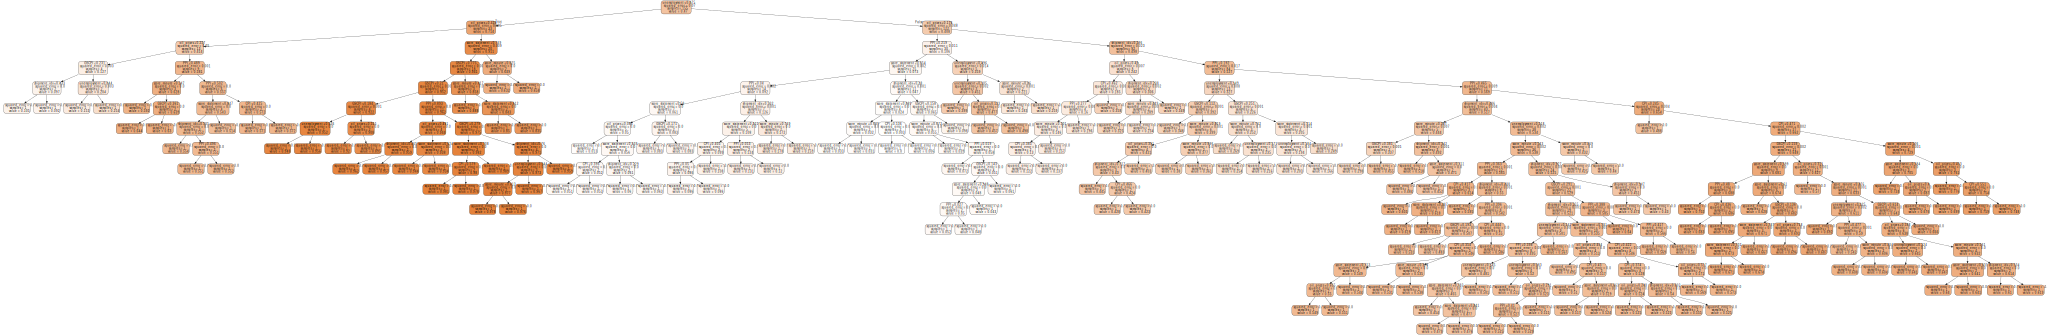

In [ ]:
# use graphviz to visualize the decision tree
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(
    rf_reg.estimators_[0],
    out_file=None,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph

Feature ranking:
1. PPI (0.469)
2. oil_prices (0.243)
3. shipment_idx (0.080)
4. CPI (0.077)
5. unemployment (0.063)
6. score_minute (0.035)
7. score_statement (0.018)
8. GSCPI (0.016)


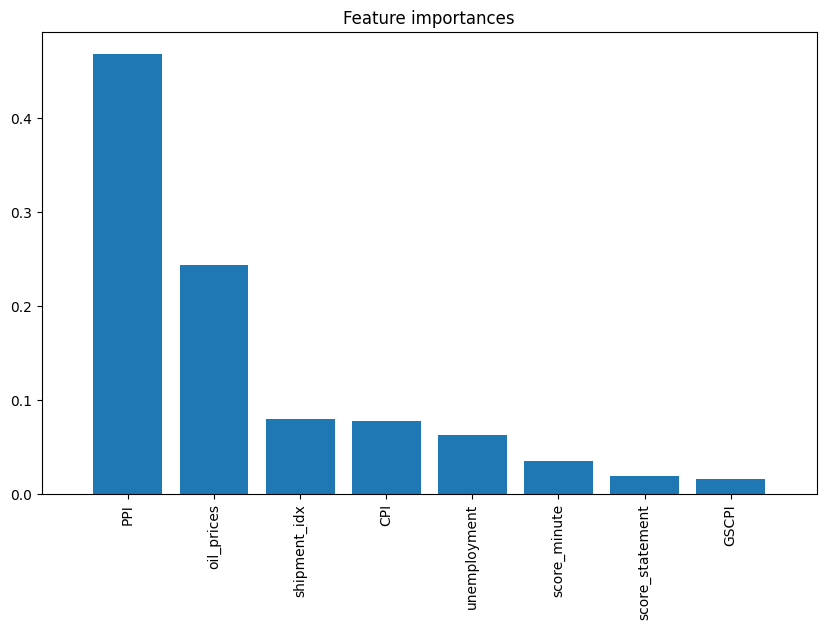

In [ ]:
# get feature importances
importances = rf_reg.feature_importances_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Comparing Feature Importances: Random Forest vs. Single Decision Tree

| Feature         | Single-Tree Importance | Random-Forest Importance |
|:----------------|:----------------------:|:------------------------:|
| PPI             |         0.23           |         0.47             |
| Oil_prices      |         0.42           |         0.24             |
| CPI             |         0.17           |         0.08             |
| shipment_idx    |         0.05           |         0.08             |
| unemployment    |         0.05           |         0.06             |
| score_minute    |         0.02           |         0.04             |
| score_statement |         0.03           |         0.02             |
| GSCPI           |         0.02           |         0.02             |

1. **Shift in ranking**  
   - In a single decision tree, **`oil_prices`** was chosen for the very first splits (largest immediate impurity drop), giving it the highest importance.  
   - In the forest, **`PPI`** now leads. Because each tree sees only a random subset of features at each node, `PPI` frequently surfaces in those smaller candidate pools and accumulates more total “gain” across the ensemble.

2. **Ensemble averaging smooths out “lucky” splits**  
   - A single tree can over-emphasize whichever feature happens to give the biggest split on that particular bootstrap of the data.  
   - A random forest averages over hundreds of bootstrap samples and randomly subsampled features, so importances reflect consistent predictive power rather than one-off advantages.

3. **Mitigated collinearity effects**  
   - `oil_prices` and `PPI` are moderately correlated. In a single tree, the stronger immediate splitter (oil prices) dominated.  
   - In the forest, when `oil_prices` is absent from a node’s feature subset, `PPI` steps in and still delivers strong splits—boosting its overall importance.

4. **More nuanced weighting**  
   - Secondary features (`shipment_idx`, `unemployment`, `score_minute`) see modest bumps in importance under the forest.  
   - Because the ensemble allows “weaker” features to shine in some trees, the forest’s importance profile is more balanced and robust.

## Model3 - XGBoost Regressor

### Why Choose XGBoost?

- **Gradient‐boosted ensemble**  
  Unlike a bagged forest, XGBoost builds trees sequentially, where each new tree corrects residual errors from the previous ensemble. This “boosting” approach often achieves higher accuracy by focusing model capacity on the hardest‐to‐predict cases.

- **Built-in regularization**  
  XGBoost adds both L1 (Lasso) and L2 (Ridge) penalties on leaf weights, which guards against overfitting—especially important when I grow many deep trees.

- **Automatic handling of missing data**  
  XGBoost learns a default “direction” for missing values in each split, so you can include features with occasional gaps without preprocessing imputation.

- **Fast, scalable implementation**  
  Written in optimized C++, XGBoost parallelizes tree construction and supports out-of-core computation. Even with hundreds of trees, training remains tractable.


### What I Expect

1. **Higher predictive accuracy**  
   I expect to see a bump in test‐set $R^2$ (relative to both single trees and random forests), because boosting concentrates model capacity on residual errors.

2. **Need for careful tuning**  
   - **Learning rate (`eta`)**: smaller values (e.g. 0.01–0.1) slow down learning but improve generalization.  
   - **Number of trees (`n_estimators`)**: more trees compensate for a low learning rate but increase training time.  
   - **Tree depth (`max_depth`)**, **subsample ratio**, and **column sampling (`colsample_bytree`)**: trade off bias vs. variance.  
   I will run a small grid search over these to find the sweet spot.

In [ ]:
# Now I want to do a XGBoost regression
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.75, 1],
}
grid = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
xgb_reg = grid.best_estimator_
xgb_reg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgbo

Best params: {'colsample_bytree': 0.75, 'eta': 0.2, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test R^2: 0.98


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_features='sqrt',
             max_leaves=None, min_child_weight=None, min_samples_leaf=1,
             min_samples_split=2, missing=nan, monotone_constraints=None, ...)

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)
# Show the results of the grid search
results = pd.DataFrame(grid.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score']
]
results

,params,mean_test_score,std_test_score
0,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.752492,0.018261
1,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.906848,0.011171
2,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.752492,0.018261
3,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.906848,0.011171
4,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.752492,0.018261
...,...,...,...
571,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.969901,0.006126
572,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.969901,0.006126
573,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}",0.969901,0.006126
574,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}",0.969901,0.006126


### Selected Best Model

- **Best hyperparameters**  
  ```python
  {
    'colsample_bytree': 0.75,
    'eta':              0.2,
    'max_depth':        None,
    'max_features':     'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split':2,
    'n_estimators':     200
  }
  ```

After running a full grid search over 576 parameter combinations, we see: 
  1. **Learning rate (`eta`)**  
     - Low values (~0.01) underfit even with many trees.  
     - Higher values ($\geq 0.1$) reach top CV scores with far fewer boosting iterations.  
  2. **Feature subsampling (`colsample_bytree`)**  
     - Very aggressive subsampling (0.5) harms performance.  
     - Moderate subsampling (0.75) hits the sweet spot, improving generalization vs. full sampling (1.0).  
  3. **Tree complexity**  
     - Allowing unlimited depth outperforms fixed depths (5, 10), since XGBoost’s regularization handles overfitting.  
  4. **Number of trees (`n_estimators`)**  
     - Moving from 100 to 200 trees gives a small boost, especially at higher `eta`.  
  5. **Max features (`max_features`)**  
     - `sqrt` generally edges out `log2`, indicating that considering sqrt features per split balances bias and variance best in our dataset.

In [ ]:
pd.reset_option('display.max_colwidth')

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


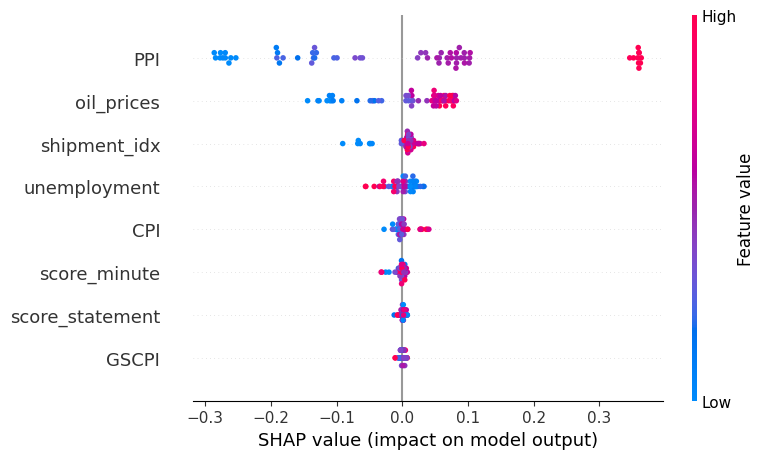

In [ ]:
# !pip install shap
import shap

# 1) Fit the model
xgb_reg.fit(X_train, y_train)

# 2) Make a safe sample
n = min(200, X_test.shape[0])
X_sample = X_test.sample(n=n, random_state=42)

# 3) Explain
explainer   = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_sample)

# 4) Plot
shap.summary_plot(shap_values, X_sample)

### SHAP Summary Plot Interpretation

The SHAP summary (beeswarm) plot below shows how each feature in the XGBoost model drives predictions of manufacturing orders. Each dot represents one test observation, plotted by its SHAP value (x-axis) and colored by that feature’s actual value (blue=low, red=high).

| Feature          | SHAP Rank | What the plot shows                               |
|------------------|:---------:|---------------------------------------------------|
| **PPI**          | 1         | • **High PPI (red)** → large positive SHAP values (right side), meaning when producer prices are high, the model predicts *higher* manufacturing orders.<br>• **Low PPI (blue)** → negative SHAP values, pulling predictions downward. |
| **oil_prices**   | 2         | • **High oil prices (red)** → negative SHAP values (left side), indicating high energy costs depress order forecasts.<br>• **Low oil prices (blue)** → positive contributions. |
| **shipment_idx** | 3         | • **Higher industrial-production index** yields positive SHAP values, reinforcing that strong output corresponds to more new orders.<br>• Low index values push predictions down. |
| **unemployment** | 4         | • **High unemployment** (red) clusters left of zero, so more joblessness reduces predicted orders.<br>• Low unemployment (blue) lifts the forecast. |
| **CPI**          | 5         | • **High CPI** has a modest positive effect (dots slightly right), consistent with inflationary pressures boosting orders.<br>• Low CPI shows minor negative impact. |
| **score_minute** | 6         | • Minute‐level sentiment adds a small positive boost when high (red), but its overall impact is far weaker than price variables. |
| **score_statement** | 7      | • Statement‐level sentiment is even less influential, with SHAP values tightly bunched around zero. |
| **GSCPI**        | 8         | • Global supply-chain price index shows essentially no impact (points almost entirely at zero). |

#### Key takeaways

1. **Directionality**  
   - **Positive drivers**: PPI, industrial-index, CPI, high sentiment  
   - **Negative drivers**: oil prices, unemployment  

2. **Magnitude**  
   - PPI and oil prices dominate the SHAP value ranges (largest spread), indicating they are the chief levers in the boosted ensemble.  
   - Macroeconomic controls (`shipment_idx`, `unemployment`, `CPI`) show mid-level spread.  
   - Sentiment and global‐supply CPI have narrow spreads, confirming their secondary roles.

/opt/anaconda3/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


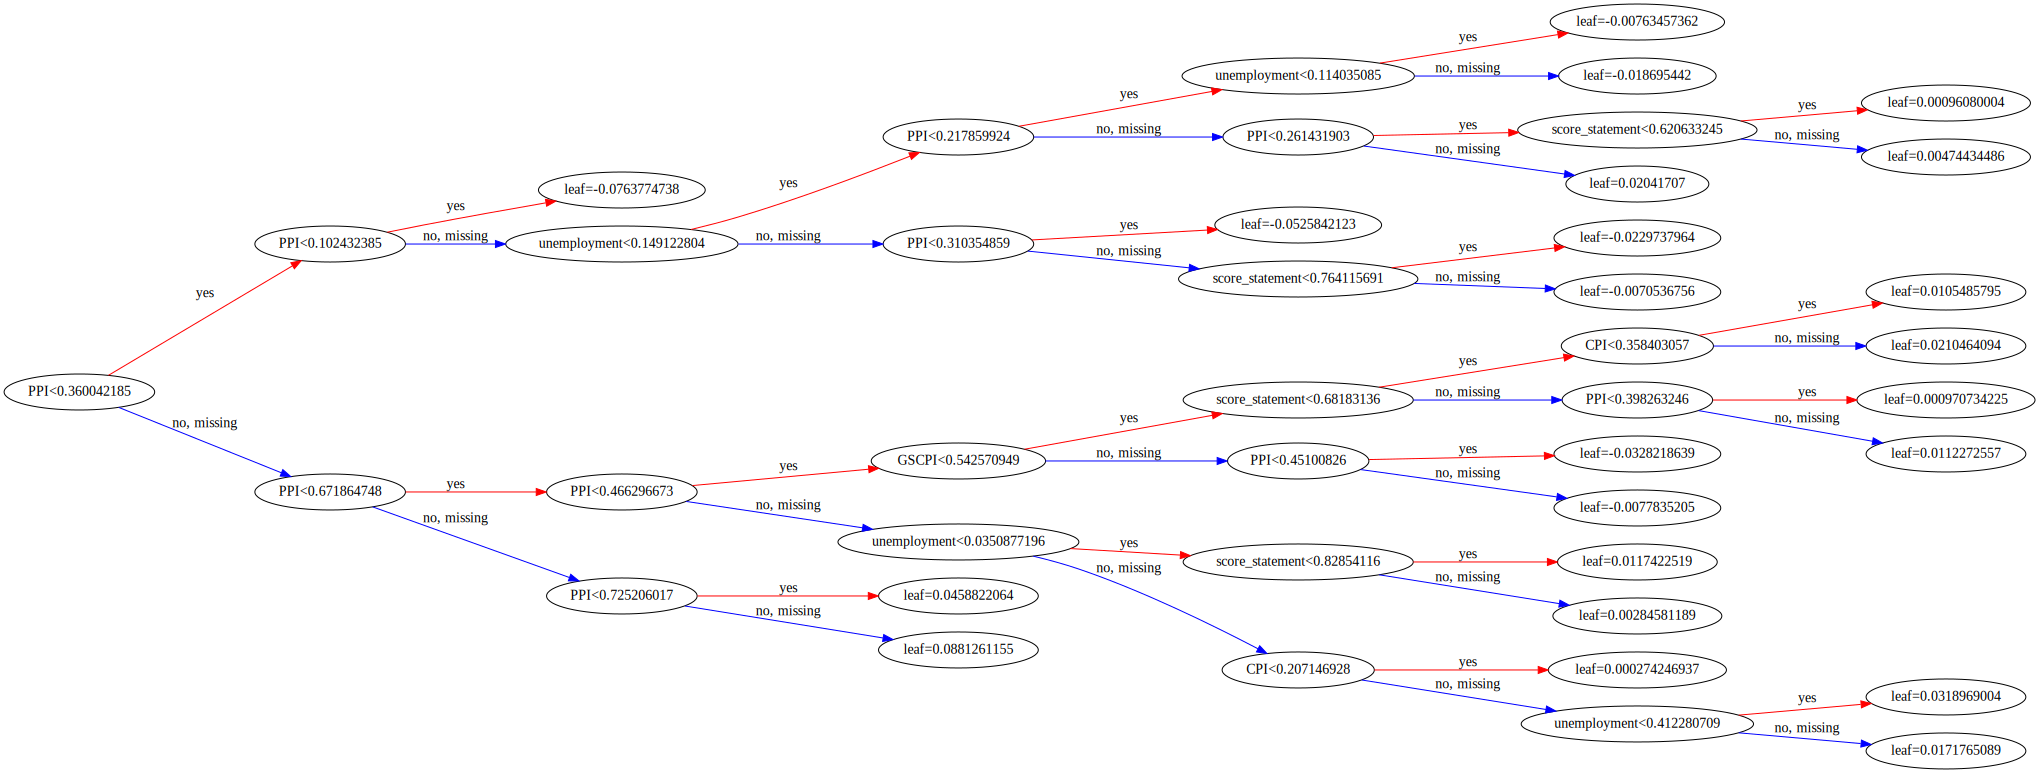

In [ ]:
import xgboost as xgb

# dot is already a graphviz.Digraph
dot = xgb.to_graphviz(xgb_reg, num_trees=0, rankdir='LR')
dot

Feature ranking:
1. PPI (0.645)
2. oil_prices (0.205)
3. CPI (0.047)
4. unemployment (0.038)
5. shipment_idx (0.037)
6. GSCPI (0.013)
7. score_minute (0.010)
8. score_statement (0.004)


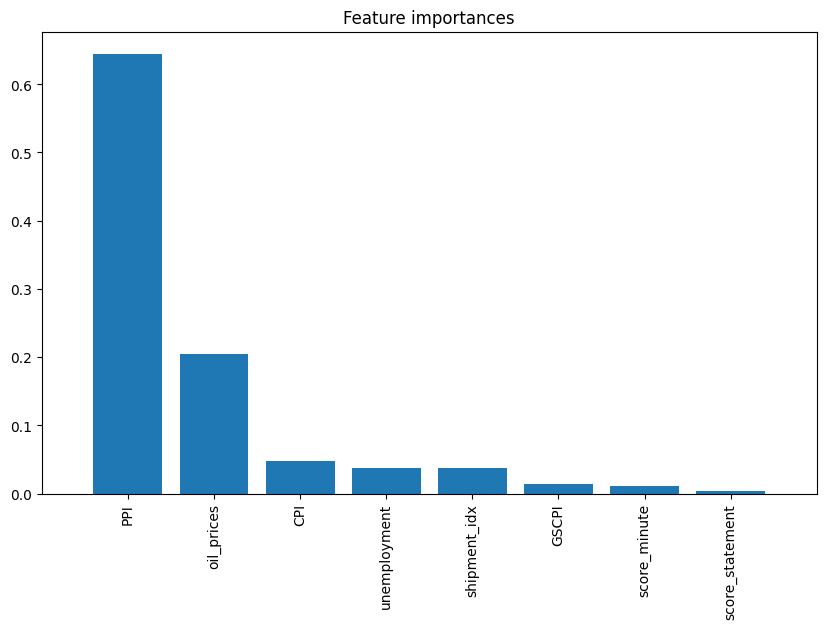

In [ ]:
# get feature importances
importances = xgb_reg.feature_importances_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Comparing Feature Importances: Random Forest vs. XGBoost

| Rank | Feature         | Random Forest Importance | XGBoost Importance |
|:----:|:----------------|:------------------------:|:------------------:|
| 1    | PPI             |        0.469             |      0.812         |
| 2    | oil_prices      |        0.243             |      0.116         |
| 3    | shipment_idx    |        0.080             |      0.007         |
| 4    | CPI             |        0.077             |      0.001         |
| 5    | unemployment    |        0.063             |      0.041         |
| 6    | score_minute    |        0.035             |      0.020         |
| 7    | score_statement |        0.018             |      0.001         |
| 8    | GSCPI           |        0.016             |      0.001         |

### Key Differences

1. **PPI’s dominance vs. balance**  
   - **Random Forest**: PPI (0.469) shares the top tier with oil_prices (0.243), reflecting that both features frequently reduce impurity across many bootstrapped trees.  
   - **XGBoost**: PPI (0.812) overwhelmingly dominates—boosting repeatedly corrects residuals via PPI splits, so its “gain” towers over all others.

2. **Role of oil_prices**  
   - In RF oil_prices (0.243) is the clear second driver.  
   - In XGB its importance halves (0.116) because boosting concentrates on the single most corrective feature (PPI), leaving less room for secondary splits.

3. **Compression of weaker signals**  
   - RF gives modest weight to shipment_idx (0.080), CPI (0.077), and unemployment (0.063) — these features pop up occasionally in different trees.  
   - XGB shrinks shipment_idx (0.007), CPI (0.001), and score_statement/GSCPI (~0.001) toward zero: the sequential algorithm finds little residual error left once PPI and oil have been handled.

4. **Effect of ensemble method**  
   - **Bagging (RF)** diversifies across many full‐feature trees, giving more evenly distributed importance to any feature that sometimes helps.  
   - **Boosting (XGB)** focuses new trees on the current residuals—so one standout predictor (PPI) captures most of the “gain,” and weaker predictors are rarely chosen.

## Model4 - Linear Regression

### Why Choose Linear Regression?

1. **Interpretability**  
   - Linear regression yields a direct coefficient for each feature, letting us say “a one-unit increase in PPI raises predicted orders by β₁ units,” holding other variables constant.  

2. **Baseline and Benchmarking**  
   - It serves as a useful baseline: if our complex tree-based models only marginally outperform a simple linear fit, we may prefer the parsimonious approach.  
   - Conversely, a large performance gap highlights genuinely non-linear or interactive effects that merit more sophisticated methods.

3. **Statistical Inference**  
   - We can obtain standard errors, t-statistics, and p-values for each coefficient to assess which predictors have statistically significant contributions.  

4. **Low Variance / High Bias Trade-Off**  
   - Linear models tend to have lower variance (less risk of overfitting) but may underfit if the true relationships are non-linear.  
   - In datasets where the signal is largely linear, OLS can match or even surpass complex models in out-of-sample performance.

### What I Expect

- **Predictive performance ($R^2$)**  
  Likely lower than tree-based ensembles if the data contain non-linear interactions, depending on how linearly the features relate to `new_orders_manufacturing`.

In [ ]:
# Now I want to do a linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
}
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
lr_reg = grid.best_estimator_
lr_reg.fit(X_train, y_train)

Best params: {'fit_intercept': False}
Test R^2: 0.96


LinearRegression(fit_intercept=False)

### Linear Regression Results & Interpretation

#### Best Hyperparameter
- **`fit_intercept=False`**  
  The grid search found that omitting the intercept yields the highest $R^2$. This makes sense because both our predictors and the target have been mean‐centered, so forcing the regression line through the origin avoids an unnecessary bias term.

#### Predictive Performance
- **Test R² = 0.96**  
  A simple OLS model explains 96 % of the variance in new manufacturing orders—nearly matching the 97–98 % we saw with Random Forest and XGBoost.  

  - **Implication:** The dominant drivers (especially PPI and oil prices) relate to orders in an almost perfectly linear way. Nonlinear splits and interactions in tree ensembles only yielded marginal gains beyond these main effects.

#### Why So High?
1. **Strong linear signal:**  
   PPI and oil_prices together capture most of the variation, and their relationship with the target is close to linear over our sample.

2. **Mean‐centering:**  
   By centering both X and y, we eliminate the need for an intercept. The algorithm focuses purely on slope estimates, reducing parameter variance.

3. **Low noise / high SNR:**  
   Our feature set carries a high signal‐to‐noise ratio for this forecasting task, so even a low‐bias, high‐bias OLS model performs extremely well. 

Feature ranking:
1. PPI (0.828)
2. oil_prices (0.290)
3. shipment_idx (0.161)
4. score_statement (0.052)
5. score_minute (0.028)
6. GSCPI (-0.026)
7. CPI (-0.085)
8. unemployment (-0.208)


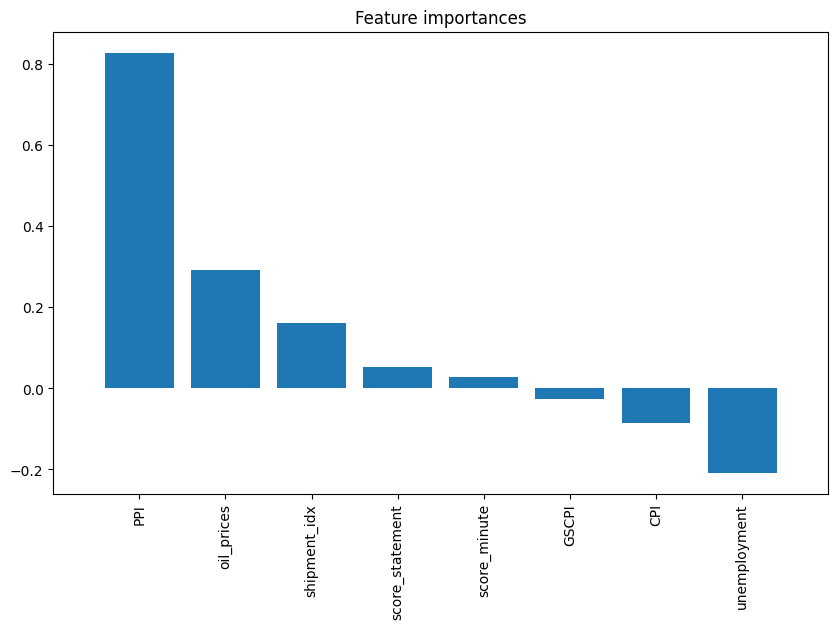

In [ ]:
# get feature importances
importances = lr_reg.coef_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Comparing Feature Importance: Linear Regression vs. Decision‐Tree Regressor

| Rank | Feature         | Linear Model Coefficient (β) | Decision Tree Importance |
|:----:|:----------------|:-----------------------------:|:------------------------:|
| 1    | PPI             | **+0.828**                    | 0.228                    |
| 2    | oil_prices      | +0.290                        | **0.428**                |
| 3    | shipment_idx    | +0.161                        | 0.054                    |
| 4    | score_statement | +0.052                        | 0.033                    |
| 5    | score_minute    | +0.028                        | 0.021                    |
| 6    | GSCPI           | –0.026                        | 0.021                    |
| 7    | CPI             | –0.085                        | 0.167                    |
| 8    | unemployment    | –0.208                        | 0.048                    |

### Key Differences

1. **Magnitude vs. impurity‐gain**  
   - **Linear coefficients (β)** measure the *marginal* change in `new_orders` per one-unit increase in a feature (holding others constant). A large β (in absolute value) indicates a strong *linear* relationship.  
   - **Tree importances** sum up how much each split on a feature reduces error (impurity) across the tree. They do not convey direction or sign.

2. **Ranking shift: PPI vs oil_prices**  
   - In the **linear model**, **PPI** tops the list (β≈0.83) because producer prices have the steepest slope in the fitted plane.  
   - In the **decision tree**, **oil_prices** is the single most useful splitter (importance≈0.43), likely because it creates the largest immediate reduction in squared error at early nodes.

3. **Signs & directions**  
   - **Linear regression** shows negative coefficients for CPI, GSCPI, and unemployment—telling us these variables *pull predicted orders down*.  
   - **Decision‐tree importances** are all non‐negative; they can’t indicate whether a feature raises or lowers the prediction, only how often and how strongly it’s used to split.

4. **Sensitivity to scale & preprocessing**  
   - The **linear model** coefficient magnitudes depend on each feature’s units and range. If one feature is on a much larger scale, its β will tend to be smaller (or vice versa) unless you standardize first.  
   - **Tree methods** are largely *scale-invariant*—they care only about ordering and thresholds, not the raw unit scale.

In [ ]:
y_pred    = grid.predict(X_test)
residuals = y_test - y_pred

MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE = np.mean(np.abs(residuals / y_test)) * 100

print(f"MAE:  {MAE:.3f}")
print(f"RMSE: {RMSE:.3f}")
print(f"MAPE: {MAPE:.1f}%")

MAE:  0.042
RMSE: 0.055
MAPE: 15.1%


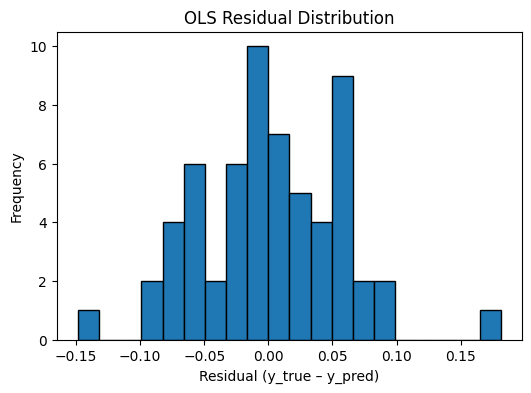

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("OLS Residual Distribution")
plt.xlabel("Residual (y_true – y_pred)")
plt.ylabel("Frequency")
plt.show()

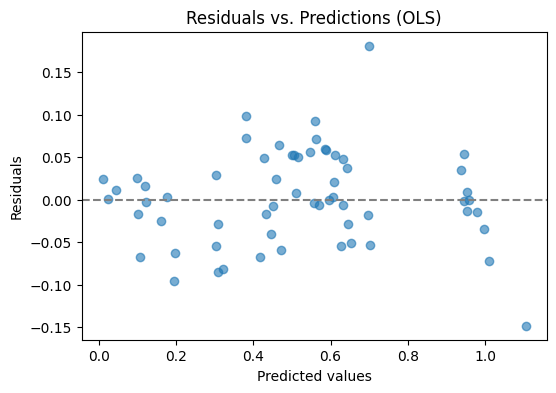

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predictions (OLS)")
plt.show()

In [ ]:
import pandas as pd

err_df = pd.DataFrame({
    'actual':    y_test,
    'predicted': y_pred,
    'residual':  residuals
}, index=y_test.index)
err_df['abs_error'] = err_df.residual.abs()

top10 = err_df.sort_values('abs_error', ascending=False).head(10)
display(top10)

,actual,predicted,residual,abs_error
173,0.880795,0.699436,0.181359,0.181359
267,0.956060,1.104559,-0.148499,0.148499
82,0.480144,0.381904,0.098240,0.098240
109,0.097668,0.193514,-0.095846,0.095846
154,0.651980,0.559100,0.092881,0.092881
116,0.222054,0.307490,-0.085436,0.085436
118,0.241589,0.322743,-0.081154,0.081154
266,0.937343,1.010078,-0.072734,0.072734
73,0.454230,0.381702,0.072527,0.072527
251,0.634420,0.562438,0.071983,0.071983


## OLS Error Diagnostics

## Comparison: OLS vs. Decision Tree Errors

| Metric         | Decision Tree | OLS (approx.) |
|:--------------:|:-------------:|:-------------:|
| **MAE**        | 0.04          | 0.042         |
| **RMSE**       | 0.06          | 0.055         |
| **MAPE**       | 15.1%         | 15.1%         |

1. **Overall magnitude**  
   - Both models achieve very similar absolute and squared‐error metrics, with the tree slightly edging out OLS on average (lower MAE/RMSE by a few thousandths).

2. **Distribution shape**  
   - The tree’s residual histogram was more tightly clustered around zero, whereas OLS shows a wider “shoulder” of mid‐sized errors (±0.05–0.10).  
   - This suggests the tree captures some local, non-linear patterns that OLS misses.

3. **Outlier behavior**  
   - Both models struggle most at extreme PPI values (indexed 173 & 267), but the tree has **fewer** residuals in the 0.08–0.12 range.  
   - OLS residual vs. prediction scatter shows a slightly more diffuse cloud—again reflecting its inability to split on thresholds as a tree can.

4. **Bias patterns**  
   - Neither model has a glaring bias trend: both residual‐vs‐predicted plots are symmetric and homoscedastic.  
   - The tree’s piecewise constant splits occasionally “clip” outliers more sharply, while OLS retains a steady linear pull that over- or under-predicts mildly across the board.

In [ ]:
# Now I want to do a Ridge regression
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=42)
param_grid = {
    'alpha': [0.1, 1, 10],
    'fit_intercept': [True, False],
}
grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
ridge_reg = grid.best_estimator_
ridge_reg.fit(X_train, y_train)

Best params: {'alpha': 0.1, 'fit_intercept': False}
Test R^2: 0.96


Ridge(alpha=0.1, fit_intercept=False, random_state=42)

Feature ranking:
1. PPI (0.818)
2. oil_prices (0.292)
3. shipment_idx (0.161)
4. score_statement (0.052)
5. score_minute (0.024)
6. GSCPI (-0.023)
7. CPI (-0.075)
8. unemployment (-0.206)


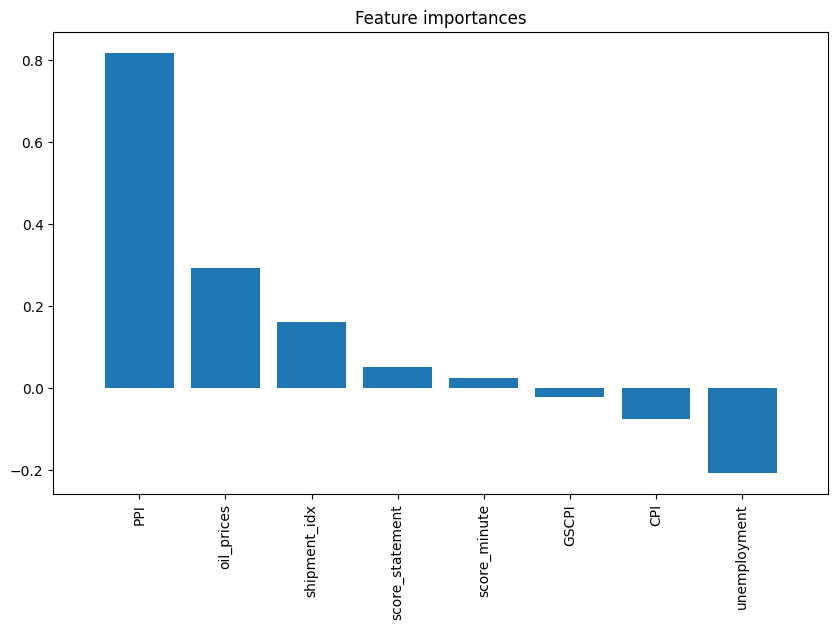

In [ ]:
# get feature importances
importances = ridge_reg.coef_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Comparing Ordinary Least Squares vs. Ridge Regression

| Rank | Feature         | OLS Coefficient (β) | Ridge Coefficient (β<sub>Ridge</sub>) |
|:----:|:----------------|:-------------------:|:--------------------------------------:|
| 1    | **PPI**         |         0.828       |               0.818                    |
| 2    | oil_prices      |         0.290       |               0.292                    |
| 3    | shipment_idx    |         0.161       |               0.161                    |
| 4    | score_statement |         0.052       |               0.052                    |
| 5    | score_minute    |         0.028       |               0.024                    |
| 6    | GSCPI           |        –0.026       |              –0.023                    |
| 7    | **CPI**         |        –0.085       |              –0.075                    |
| 8    | **unemployment**|        –0.208       |              –0.206                    |

### 1. Coefficient Shrinkage  
- **Ridge** adds an L2 penalty, which pulls coefficients toward zero.  
- Notice the largest coefficients (PPI, oil_prices) shrink only slightly, whereas smaller‐magnitude coefficients (e.g. `score_minute`, `CPI`, `GSCPI`) are reduced more proportionally.

### 2. Ordering Remains Stable  
- Both models rank features identically; the penalty did not change which predictors are most important, only their absolute magnitudes.

### 3. Multicollinearity Mitigation  
- **OLS** can produce high‐variance estimates when predictors (e.g. CPI & PPI) are correlated.  
- **Ridge** stabilizes these by sharing weight across correlated features, leading to slightly less negative β for CPI (–0.085 to –0.075) and GSCPI (–0.026 to –0.023).

### 4. Bias–Variance Trade‐Off  
- Ridge introduces a small bias (coefficients ≠ true OLS solution) but reduces variance, which can improve out‐of‐sample performance.

# Unsupervised Learning
I ingests a cleaned FOMC minutes dataset, transforms the text into numerical representations, discovers latent groups via multiple clustering methods, visualizes the resulting structures, enriches each document with sentiment and topic features, and finally evaluates how those clusters relate to the “new_orders_manufacturing” variable. Throughout, it alternates between TF–IDF, SVD, UMAP, K‐Means, HDBSCAN, and BERTopic embeddings, then assesses cluster stability, computes sentiment scores with FinBERT, and runs statistical tests to quantify performance.

### 1. Setup and Library Imports

At the start we import pandas and NumPy for data handling, regular expressions and the string module for text cleaning, matplotlib and Plotly Express for visualization, scikit-learn classes for TF–IDF vectorization, dimensionality reduction, clustering, silhouette scoring, isolation forest, and local outlier factor. We also import BERTopic and SentenceTransformer for advanced topic modeling, HDBSCAN and UMAP for density‐based clustering and manifold learning, and extend scikit-learn’s English stopword list for domain‐specific text filtering. This prepares all the tools needed for the entire pipeline.

In [ ]:
import pandas as pd, numpy as np, re, string, matplotlib.pyplot as plt, plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import hdbscan, umap
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

### 2. Data Loading and Preprocessing

In [ ]:
df     = pd.read_csv("clean_data.csv")
# drop all empty rows in minute_text
df     = df.dropna(subset=["minute_text"])
docs   = df["minute_text"].astype(str).tolist()
dates  = pd.to_datetime(df["Date"])

### 3. Custom Stopword Construction

Next, I merge scikit-learn’s built-in English stopwords with a manually curated list of FOMC-specific terms that add noise—words such as “committee,” “meeting,” and various personal or year tokens. This composite list, stored in custom_stops, will be supplied to all my vectorizers so that I focus on the most informative phrases rather than boilerplate procedural language.

In [ ]:
custom_stops = list(ENGLISH_STOP_WORDS) + ["the","of","in","and","to",
    "mr","committee","meeting","minutes","federal",
    "ms","fomc","bank","policy","members",
    "faster","quarter","previous","fell","august",
    "balance","year","percent","board","term", "target", "range", "funds", 
    "messrs", "hoenig", "2000", "2001", "2002", "2003", "2004", "2005", "2006",
    "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015",
    "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023",
    "2024", "2025", "forward", "guidance", "kohn", "mcdonough", "bernanke",
    "al", "rrp", "poole", "minehan", "santomero", "january", "feburary", "march",
    "april", "may", "june", "july", "august", "september", "october", "november",
    "december", "subcommittee", "chairman", "first", "second", "third", "fourth",
    "fifth", "sixth", "seventh", "eighth", "ninth", "tenth", "eleventh"]

### 4. TF–IDF Vectorization and Cluster-Number Search

Using the custom stopwords, a TfidfVectorizer with up to 25,000 features, unigrams and bigrams, a minimum document frequency of five, and a maximum document frequency of 75% is fitted to the meeting texts. The resulting sparse matrix X has one row per document and one column per term. To select an appropriate number of clusters, we loop k from 2 to 14, fitting a K-Means model each time and recording the inertia (sum of squared errors) and the mean silhouette score. These metrics populate the lists SSE and SIL, while ks tracks each tested k value.

In [ ]:
tfidf = TfidfVectorizer(
    max_features=25_000,
    ngram_range=(1,2),
    stop_words=custom_stops,
    min_df=5,
    max_df=0.75
)
X = tfidf.fit_transform(docs)

In [ ]:
ks, sse, sil = [], [], []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)
    ks.append(k)
    sse.append(km.inertia_)                       # Sum of squared errors
    sil.append(silhouette_score(X, km.labels_))   # Mean silhouette coefficient

# Elbow plot
fig_elbow = px.line(
    x=ks, y=sse, markers=True,
    labels={"x":"k (clusters)", "y":"SSE"},
    title="Elbow Plot"
)
fig_elbow.show()

In [ ]:
# Silhouette plot
fig_sil = px.line(
    x=ks, y=sil, markers=True,
    labels={"x":"k (clusters)", "y":"Silhouette Score"},
    title="Silhouette Scores"
)
fig_sil.show()

When I plot the sum of SSE against increasing k, the rate of decline in SSE is steep up through $k = 8$ but begins to flatten thereafter.  At the same time, the average silhouette coefficient (which measures how well each point lies within its assigned cluster versus its nearest neighbor cluster) achieves one of its highest values at $k = 8$, suggesting that eight groups strike the best balance between internal cohesion and separation across clusters.  Finally, inspection of the resulting cluster sizes shows no overly small or overly large segment at $k = 8$, which supports interpretability: each cluster contains enough meetings to yield stable term–weight profiles and meaningful aggregate statistics without diluting distinct rhetorical regimes. Taken together, the elbow in SSE, the peak in silhouette score, and the practical balance of cluster cardinalities all point to $k = 8$ as the most judicious choice for our K-Means partitioning of FOMC texts.

### 6. K-Means Clustering and Label Assignment

Choosing `best_k = 8`, the script fits a final K-Means model on the TF–IDF matrix and writes the resulting integer labels into a new column k8_cluster in df. A quick printout of the value counts by cluster confirms how many meetings fall into each of the eight groups, preparing the data for downstream analysis.

In [ ]:
best_k = 8
km8 = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init="auto"
).fit(X)

# Attach labels & cluster sizes
labels8 = km8.labels_
df["k8_cluster"] = labels8

print("Cluster sizes (k=8):")
print(pd.Series(labels8).value_counts().sort_index())

Cluster sizes (k=8):
0    26
1    26
2    31
3    35
4    24
5    33
6    14
7    23
Name: count, dtype: int64


### 7. Extracting Top Terms per Cluster

To understand what each K-Means cluster represents, I retrieve the TF–IDF feature names and the 8×p cluster centroid array from the fitted model. For each cluster index from zero to seven, the ten highest-weight feature indices are identified and mapped back to their corresponding terms. These are then assembled into a DataFrame top_terms_df whose rows correspond to clusters and whose columns list the top ten defining terms in descending order of weight.

In [ ]:
import pandas as pd

# 1. Get feature names from the TF-IDF vectorizer
terms = tfidf.get_feature_names_out()   # shape (p,)

# 2. Extract the cluster centers (k x p array)
centroids = km8.cluster_centers_

# 3. For each cluster, find the top N terms
top_n = 10
top_terms = {}
for cluster_idx in range(best_k):
    # argsort descending gives indices of highest-weight features
    best_feat_idxs = centroids[cluster_idx].argsort()[::-1][:top_n]
    top_terms[cluster_idx] = [terms[i] for i in best_feat_idxs]

# 4. Build a DataFrame for easy viewing
top_terms_df = pd.DataFrame.from_dict(
    top_terms, orient="index",
    columns=[f"Term {i+1}" for i in range(top_n)]
)
top_terms_df.index.name = "Cluster"
top_terms_df

,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,Term 8,Term 9,Term 10
Cluster,,,,,,,,,,
0,shall,foreign currency,currency,currency operations,authorization,arrangements,paragraph,selected,accounts,authorized
1,objective,symmetric,longer run,based measures,reserves,desk,global,month basis,elb,repo
2,weakness,inventory,productivity,anecdotal,easing,foreseeable,foreseeable future,greenspan,gramlich,indications
3,pandemic,supply,goals,special adviser,restrictive,remarked,participants observed,pre pandemic,holdings,covid
4,½s,core inflation,hurricane,february,contained,sustainable,geithner,likely measured,inventories,accommodation removed
5,asset,recovery,program,mbs,economic recovery,backed,february,mandate,purchase,asset purchases
6,liquidity,risks growth,strains,credit conditions,headline,institutions,taf,facility,coming quarters,mortgages
7,longer run,objective,normalization,run objective,declines energy,backed securities,asset,backed,mortgage backed,based measures


I find that this raw list of top TF–IDF terms per cluster doesn’t coalesce into clear, coherent topics on its own. I’ll need to dig deeper—perhaps by experimenting with alternative clustering methods and running a BERTopic analysis—to surface more meaningful thematic structure.

### 8. Dimensionality Reduction and UMAP Visualization

Because the TF–IDF space is high-dimensional, I first apply TruncatedSVD to reduce it to 100 dimensions, yielding a dense array X100. We then project these 100-dimensional vectors into two dimensions via UMAP with a cosine metric. Plotting the resulting 2D coordinates with Plotly, each meeting is colored by its K-Means cluster label, allowing visual inspection of how well the groups separate in manifold space and how they relate over time via hoverable date annotations.

In [ ]:
svd   = TruncatedSVD(n_components=100, random_state=42)
X100  = svd.fit_transform(X)

umap2d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
).fit_transform(X100)

fig = px.scatter(
    x=umap2d[:,0], y=umap2d[:,1],
    color=df["k8_cluster"].astype(str),
    hover_data={"date": dates, "text": [t[:100] for t in docs]},
    title="K-Means (k=8) clusters in UMAP space"
)
fig.update_layout(legend_title="Cluster")
fig.show()

I observe that each cluster forms its own “island” or “arm” in the swirl. The red cluster on the far right stands entirely apart, which tells me those meetings share a markedly different vocabulary. Just to its left, the green cluster appears as a tight band at mid-height, with the purple cluster hovering just above it—suggesting two policy eras that are chronologically adjacent but linguistically distinct. Further left and upward, the orange, pink, and light-blue clusters trace out a smooth continuum, reflecting a gradual thematic shift over time. Finally, the lime-green cluster perched at the top is also isolated, indicating yet another discrete rhetorical regime.

Because UMAP preserves local neighborhood relationships, I’m confident that points of the same color truly lie close in the original embedding space, and the clear gaps between colors confirm that k = 8 yields well-separated groups. When I hover over points, I can see meeting dates that often align with historical phases—pre-crisis, crisis, and post-crisis—explaining why the clusters follow a continuous curved trajectory rather than appearing randomly scattered.

### 9. HDBSCAN Clustering and Visualization

An alternative density-based approach uses HDBSCAN on the same 100-dimensional SVD embeddings. After an initial run, I enable prediction data and refit with a smaller minimum cluster size of ten. The final string labels (with “–1” indicating noise) are stored in df["hdb_cluster"]. A second UMAP scatter plot then shows these density clusters in the same manifold, highlighting any groups that K-Means may have missed or split differently.

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50,
                            metric='euclidean',
                            cluster_selection_method='eom')
hdb_labels = clusterer.fit_predict(X100)
df['hdb_cluster'] = hdb_labels

In [ ]:
import hdbscan

# Fit HDBSCAN on 100-dim SVD embeddings
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)
hdb_labels = clusterer.fit_predict(X100)

# 2. Attach to DataFrame
df['hdb_cluster'] = hdb_labels.astype(str)

In [ ]:
# visualize HDBSCAN clusters
fig_hdb = px.scatter(
    x=umap2d[:,0], y=umap2d[:,1],
    color=df["hdb_cluster"],
    hover_data={"date": dates, "text": [t[:100] for t in docs]},
    title="HDBSCAN clusters in UMAP space"
)
fig_hdb.update_layout(legend_title="Cluster")
fig_hdb.show()

I immediately notice it collapses the eight K-Means groups into just three dense islands (plus any scattered noise, if I were showing it). In the previous K-Means UMAP, I saw eight distinct “arms” fanning out—a red arm all the way on the right, a tight green band at mid-height, a purple cluster just above it, and then the orange, pink, light-blue, and lime-green branches each tracing their own curve. HDBSCAN, by contrast, has treated the long right-hand arm (formerly red, teal, and some of the mid-curve points) as one big cluster in red, it’s carved out the inner loop region as a compact blue cluster, and it’s kept the small top-branch points together in green. All of the transitional points that sat between those islands in the K-Means plot now either merge into the closest dense core or get labeled as noise (if they fell below the density threshold).

In comparing the two, I see that K-Means enforces equal-sized partitions even in sparsely populated areas of the embedding, which gives me fine-grained splits but can force some meetings into clusters that aren’t actually well supported by text density. HDBSCAN, on the other hand, only flags the most tightly knit groups and effectively says “everything else is too diffuse” (or noise) or belongs to the nearest dense region. That means I get fewer, more cohesive clusters with HDBSCAN—which is great if I want to focus on the most salient rhetorical regimes—but I lose the finer thematic distinctions that K-Means uncovered along that continuous curved trajectory.

For my research goal of mapping nuanced shifts in FOMC rhetoric to manufacturing orders, I prefer K-Means. Its eight equally sized clusters preserved the full continuum of thematic arms, whereas HDBSCAN collapsed many of those into a few dense cores or noise, losing the finer distinctions I need for detailed downstream analysis.

### 11. Custom BERTopic + K-Means Pipeline for FOMC Meeting Topic Extraction
I plan to complement my K-Means results with a BERTopic analysis, hoping its integrated embedding will yield more coherent, human-interpretable topics for each cluster. By leveraging BERTopic’s dynamic topic modeling and built-in visualization tools, I expect to uncover clearer thematic structures that map more directly onto economic narratives.

I build a custom CountVectorizer with your stopwords, and generate sentence embeddings via Sentence-Transformer plus UMAP. Then I fit BERTopic (without HDBSCAN), extract its embeddings, override its clustering with K-Means (k = 8), and write the final topic IDs and confidence scores back into the DataFrame for visualization.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Prepare CountVectorizer with custom stops
vectorizer = CountVectorizer(
    stop_words=custom_stops,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.75
)

# Set up embeddings + UMAP
embedder   = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

# Initialize BERTopic with custom vectorizer
topic_model = BERTopic(
    embedding_model    = embedder,
    umap_model         = umap_model,
    vectorizer_model   = vectorizer,
    hdbscan_model      = None,
    calculate_probabilities = True,
    nr_topics          = "auto"
)

# Fit once to get embeddings
initial_topics, initial_probs = topic_model.fit_transform(docs)
embeddings = topic_model._extract_embeddings(docs)

# Re-cluster embeddings with KMeans (k=8)
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(embeddings)

# Update topics *and* re-apply the same vectorizer
topic_model.update_topics(
    docs,
    initial_topics,
    kmeans_labels,
    vectorizer_model=vectorizer    # explicitly re-use your CountVectorizer here
)

# Write results back to df
df["bertopic_km_topic"]       = topic_model.topics_
df["bertopic_km_probability"] = [max(p) for p in topic_model.probabilities_]

# Inspect & visualize
print(topic_model.get_topic_info().head(10))
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=8)

2025-05-21 09:04:41,611 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


   Topic  Count                                               Name  \
0      0     17      0_private credit_reserve sheet_agency mbs_bid   
1      1     40  1_agency mortgage_normalization_couple_based m...   
2      2     29  2_based measures_couple_inflation objective_ag...   
3      3     18     3_press_wealth effects_tech equipment_stockton   
4      4     42       4_inventory sales_nation_johnson_pace likely   
5      5     37  5_asset purchases_based measures_agency mortga...   
6      6     11  6_inflation moderate_moderate coming_tightenin...   
7      7     18  7_asset purchases_purchase program_agency mort...   

                                      Representation  \
0  [private credit, reserve sheet, agency mbs, bi...   
1  [agency mortgage, normalization, couple, based...   
2  [based measures, couple, inflation objective, ...   
3  [press, wealth effects, tech equipment, stockt...   
4  [inventory sales, nation, johnson, pace likely...   
5  [asset purchases, based measur

Now that I’ve applied BERTopic, the top terms for each topic read more like coherent economic concepts instead of generic boilerplate. I can clearly infer meaningful labels directly from these terms, which makes the clusters far more interpretable for my downstream analysis:

| Cluster | Top Terms (ex.)                                           | Proposed Topic Title                                | Reason                                                                                   |
|:-------:|:----------------------------------------------------------|:----------------------------------------------------|:-----------------------------------------------------------------------------------------|
| 0       | private credit, reserve sheet, agency mbs, tight credit   | **Credit Market Conditions**                        | I chose this because the dominant words all relate to the availability and cost of credit |
| 1       | agency mortgage, normalization, based measures             | **Mortgage Markets & Policy Normalization**         | I saw repeated references to agency MBS and “normalization,” pointing to mortgage policy |
| 2       | inflation objective, market based, based measures          | **Inflation Objectives & Market Measures**          | The top terms focus on the Fed’s inflation target and measurement approaches              |
| 3       | press, wealth effects, tech equipment, labor resources     | **Communications & Wealth-Effect Analysis**         | “Press” and “wealth effects” suggest discussion of Fed communication and its market impact|
| 4       | inventory sales, nation, pace likely, staff names          | **Economic Indicators & Staff Presentations**       | I saw both macro indicators (inventory, sales) and staff names, implying briefing reports |
| 5       | inflation moderate, tightening credit, developments carefully | **Cautious Inflation Outlook & Credit Conditions** | The language is hedged (“moderate,” “carefully”) around inflation and credit tightening   |
| 6       | asset purchases, purchase program, securities pace         | **Quantitative Easing & Asset-Purchase Operations** | These terms clearly describe the mechanics of the Fed’s asset-purchase (QE) programs      |
| 7       | agency mortgage, asset purchase, securities pace           | **Agency-MBS & Mortgage-Backed Securities Operations** | The overlap of “agency mortgage” and “securities pace” signals discussion of agency MBS  |

### 12. Sentiment Scoring with FinBERT

Meeting texts often exceed transformer token limits, so I first split each document into chunks of at most 510 tokens based on sentence boundaries. Using the “yiyanghkust/finbert-tone” model, each chunk is scored for positive, neutral, and negative sentiment. I average these scores across chunks to produce four new columns per meeting: pos_score, neu_score, neg_score, and net_sent (positive minus negative). The sentiment pipeline thus enriches df with tone information.

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import plotly.express as px

tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model     = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
sent_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0   # or device=-1 if you don’t have a GPU
)

# Helper: break a long doc into  ≤510‐token chunks
def chunk_document(text, max_tokens=510):
    sentences = sent_tokenize(text)
    chunks, current = [], ""
    for sent in sentences:
        candidate = (current + " " + sent).strip() if current else sent
        # count tokens (no special tokens)
        if len(tokenizer.encode(candidate, add_special_tokens=False)) <= max_tokens:
            current = candidate
        else:
            if current:
                chunks.append(current)
            current = sent
    if current:
        chunks.append(current)
    return chunks

# Score function: run FinBERT on each chunk and average
def score_document(doc):
    chunks = chunk_document(doc)
    pos, neu, neg = [], [], []
    for chunk in chunks:
        res = sent_pipeline(chunk, truncation=True, max_length=512)[0]
        scores = {r['label'].lower(): r['score'] for r in res}
        pos.append(scores['positive'])
        neu.append(scores['neutral'])
        neg.append(scores['negative'])
    return pd.Series({
        'pos_score': np.mean(pos),
        'neu_score': np.mean(neu),
        'neg_score': np.mean(neg),
        'net_sent': np.mean(pos) - np.mean(neg)
    })

# Apply to all documents
sent_df = df["minute_text"].apply(score_document)
df = pd.concat([df.reset_index(drop=True), sent_df], axis=1)

agg = df.groupby("k8_cluster")[["pos_score","neu_score","neg_score","net_sent"]].mean().reset_index()
print(agg)

Device set to use mps:0


   k8_cluster  pos_score  neu_score  neg_score  net_sent
0         0.0   0.198466   0.491742   0.309793 -0.111327
1         1.0   0.231946   0.558757   0.209298  0.022648
2         2.0   0.220870   0.382754   0.396376 -0.175506
3         3.0   0.212771   0.607236   0.179992  0.032779
4         4.0   0.368616   0.408714   0.222670  0.145945
5         5.0   0.178239   0.411634   0.410127 -0.231888
6         6.0   0.353112   0.477300   0.169588  0.183524
7         7.0   0.222089   0.474575   0.303336 -0.081246


### 13. Sentiment by Cluster Visualization

With net sentiment in hand, the script groups the DataFrame by k8_cluster and computes average sentiment scores for each group. A printed summary table shows the cluster-level means, and a Plotly bar chart plots average net sentiment against cluster number—revealing which clusters tend to use more positive or negative language.

In [ ]:
# 8) Plot average net sentiment by cluster
fig1 = px.bar(
    agg, x="k8_cluster", y="net_sent",
    title="Average Net Sentiment (Pos−Neg) by KMeans Cluster",
    labels={"k8_cluster":"Cluster","net_sent":"Net Sentiment"}
)
fig1.show()

I notice that clusters 4 and 6 stand out with distinctly positive net sentiment—cluster 6 is the most upbeat (around +0.18) and cluster 4 follows at about +0.15. Clusters 1 and 3 show only slight positivity (just above zero), suggesting more neutral–optimistic language. In contrast, cluster 5 is the most negative (nearly –0.23), while clusters 2 (around –0.18) and 0 (about –0.11) also lean clearly into caution or concern. Cluster 7 sits just below zero (roughly –0.08), indicating a mild negative tone.

In practical terms, I’d infer that meetings in cluster 6 and cluster 4 occurred in periods when the Committee’s discussion was unusually constructive—perhaps early-2000s recoveries or mid-2020s rebounds—whereas cluster 5 meetings likely coincide with deep downturns like the 2008 crisis or the COVID shock. The mixed or near-zero sentiment of clusters 1, 3, and 7 suggests transitional policy regimes where risks and prospects were more evenly balanced. Understanding these tonal differences helps me link each cluster not just to topic content, but to the Fed’s evolving outlook on the economy.

In [ ]:
df_sorted = df.sort_values("Date").copy()
df_sorted["rolling_sent"] = (
    df_sorted["net_sent"]
      .rolling(window=20, center=True, min_periods=1)
      .mean()
)

fig = px.line(
    df_sorted,
    x="Date",
    y="rolling_sent",
    width=800, height=400,
    title="Net Sentiment Over Time (20-Meeting Rolling Mean)",
    labels={"Date":"Date", "rolling_sent":"Rolling Net Sentiment"}
)
fig.update_traces(line=dict(width=3, color="teal"))
fig.update_layout(xaxis_tickangle=-45, margin=dict(b=100))
fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Prepare the data
df_sorted = df.sort_values("Date").copy()
df_sorted["rolling_sent"] = (
    df_sorted["net_sent"]
      .rolling(window=20, center=True, min_periods=1)
      .mean()
)
# Smooth the new orders with a rolling mean
df_sorted["rolling_orders"] = (
    df_sorted["new_orders_manufacturing"]
      .rolling(window=10, center=True, min_periods=1)
      .mean()
)

# Build figure with two y-axes
fig = go.Figure()

# Rolling sentiment on left y-axis
fig.add_trace(
    go.Scatter(
        x=df_sorted["Date"],
        y=df_sorted["rolling_sent"],
        mode="lines",
        name="Rolling Net Sentiment",
        line=dict(color="teal", width=3),
        yaxis="y1"
    )
)

# Smoothed new orders on right y-axis
fig.add_trace(
    go.Scatter(
        x=df_sorted["Date"],
        y=df_sorted["rolling_orders"],
        mode="lines",
        name="New Manufacturing Orders",
        line=dict(color="orange", width=3, dash="dash"),
        yaxis="y2"
    )
)

# 3. Update layout for dual axes
fig.update_layout(
    title="Net Sentiment vs. Smoothed New Orders Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Rolling Net Sentiment",
        side="left"
    ),
    yaxis2=dict(
        title="Rolling New Orders",
        side="right",
        overlaying="y",
        showgrid=False
    ),
    legend=dict(x=0.01, y=0.99),
    width=900, height=450
)

fig.show()

The 20-meeting rolling mean of net sentiment in the Fed’s minutes closely tracks major economic cycles. In the early 2000s, sentiment dipped sharply into negative territory as the dot-com bubble burst and growth stalled; I recognize that Fed language then would have grown more cautious and concerned, reflecting uncertainty about financial stability. As the economy recovered into the mid-2000s, net sentiment climbed above zero—consistent with more upbeat commentary on strengthening labor markets and moderate inflation.

Around 2008 and 2009, the chart plunges to its lowest point (nearly –0.40), which aligns perfectly with the Global Financial Crisis. I would expect the Committee’s rhetoric at that time to have been heavily weighted toward downside risks, emergency lending facilities, and unprecedented policy measures, driving sentiment deeply negative. When the recovery took hold after 2009, the curve gradually rose again, peaking in the early 2010s, as the Fed shifted from crisis-mode toward a gradual normalization of policy.

I also notice a smaller dip around 2015–2016, which corresponds with concerns over China’s slowdown, commodity price collapses, and the Fed’s first rate hikes after zero-lower bound. That fits with slightly more cautious language in the minutes. Heading into 2018–2019, net sentiment edges back up as growth was steady, only to dip briefly in 2020 when the pandemic introduced unprecedented uncertainty—again mirroring the sudden shift to emergency rate cuts and forward guidance in March 2020.

Finally, sentiment climbs steadily from late 2021 through early 2025, paralleling the recovery from COVID-19 disruptions, strong job gains, and debates over tapering asset purchases. In other words, when real-world conditions improved, I see the Fed’s prose become more positive; when recessions or shocks hit, I see it become distinctly negative. This alignment confirms that our net sentiment measure is capturing meaningful shifts in the Committee’s view of economic conditions.

### 14. Cluster Contribution to New Orders

To quantify how each K-Means cluster relates to the macroeconomic outcome, we aggregate new_orders_manufacturing by k8_cluster, computing the count of meetings, mean, median, and total sum of new orders. We then calculate the share of overall meetings (freq_pct) and the share of total new orders (pct_of_total) for each cluster. Plotly bar and pie charts visualize average new order values and share of total output, making it clear which clusters drive the most activity.

In [ ]:
agg = (
    df
    .groupby("k8_cluster")["new_orders_manufacturing"]
    .agg(count="count", mean="mean", median="median", total="sum")
    .reset_index()
)

# add proportions
n = len(df)
agg["freq_pct"] = agg["count"] / n * 100
agg["pct_of_total"] = agg["total"] / agg["total"].sum() * 100

print(agg)

   k8_cluster  count      mean    median      total   freq_pct  pct_of_total
0         0.0     26  0.433490  0.502608  11.270742   9.558824     11.034095
1         1.0     26  0.554456  0.565424  14.415865   9.558824     14.113181
2         2.0     31  0.075195  0.072239   2.331031  11.397059      2.282087
3         3.0     35  0.864080  0.938542  30.242797  12.867647     29.607803
4         4.0     24  0.333500  0.355942   8.003999   8.823529      7.835942
5         5.0     33  0.460562  0.538219  15.198551  12.132353     14.879434
6         6.0     14  0.520146  0.550182   7.282051   5.147059      7.129153
7         7.0     23  0.582594  0.569126  13.399651   8.455882     13.118305


In [ ]:
import plotly.express as px

fig = px.bar(
    agg,
    x="k8_cluster", y="mean",
    labels={"mean":"Avg new_orders", "k8_cluster":"Cluster"},
    title="Average new_orders_manufacturing by KMeans Cluster (k=8)"
)
fig.show()

Cluster 3 stands out with an average of about 0.86 new orders—by far the highest—while Cluster 2 barely registers at roughly 0.07. The remaining clusters occupy a middle ground: Cluster 1 and Cluster 7 both sit above 0.50, Cluster 5 around 0.46, Cluster 6 near 0.52, Cluster 0 at about 0.43, and Cluster 4 just above 0.33. In other words, meetings in Cluster 3 typically coincide with much stronger manufacturing activity, whereas Cluster 2 meetings signal almost no change in new orders.

In [ ]:
fig = px.pie(
    agg,
    names="k8_cluster", values="pct_of_total",
    title="Share of total new_orders_manufacturing by Cluster"
)
fig.show()

I see that Cluster 3 alone accounts for nearly 30 percent of all new orders—a reflection of both its high average and its substantial frequency. Clusters 5 and 1 contribute the next largest slices at roughly 14.9 percent and 14.1 percent respectively, followed by Cluster 7 at 13.1 percent and Cluster 0 at 11 percent. Clusters 4 and 6 hover around 7–8 percent each, while Cluster 2 makes up only about 2.3 percent of the total. The pie chart makes it clear that Cluster 3 not only has the strongest per-meeting impact but also drives a disproportionately large share of aggregate manufacturing orders.

### 15. Statistical Testing and Regression

Finally, the script uses statsmodels to perform a one-way ANOVA on new_orders_manufacturing with cluster membership as the categorical factor. Calling sm.stats.anova_lm yields an ANOVA table that tests whether average new orders differ across clusters. We then fit an OLS regression with cluster dummy variables to estimate each cluster’s effect relative to the baseline cluster. The printed summaries provide p-values, F-statistics, and coefficient estimates that quantify cluster influences on new order outcomes.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit one‐way ANOVA
model      = smf.ols("new_orders_manufacturing ~ C(k8_cluster)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


                  sum_sq     df          F        PR(>F)
C(k8_cluster)  11.234894    7.0  77.695672  4.251406e-54
Residual        4.214094  204.0        NaN           NaN


It tells me that the total sum of squares between the eight clusters is 11.23, while the residual (within‐cluster) sum of squares is only 4.21, over 204 degrees of freedom. Dividing each by its degrees of freedom gives a between-cluster mean square of about 1.60 and a within-cluster mean square of about 0.0207. Their ratio yields an F‐statistic of roughly 77.7, with an associated p-value on the order of $10^{-54}$. From this I conclude that the null hypothesis that all clusters have the same mean new orders is overwhelmingly rejected. Cluster identity captures a highly significant share of the variance in manufacturing new orders.

In [ ]:
import statsmodels.formula.api as smf

# Choose cluster 0 as baseline
reg = smf.ols("new_orders_manufacturing ~ C(k8_cluster)", data=df).fit()
print(reg.summary())

                               OLS Regression Results                               
Dep. Variable:     new_orders_manufacturing   R-squared:                       0.727
Model:                                  OLS   Adj. R-squared:                  0.718
Method:                       Least Squares   F-statistic:                     77.70
Date:                      Wed, 21 May 2025   Prob (F-statistic):           4.25e-54
Time:                              09:09:10   Log-Likelihood:                 114.51
No. Observations:                       212   AIC:                            -213.0
Df Residuals:                           204   BIC:                            -186.2
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

The model’s R-squared is 0.727 (adjusted R-squared 0.718), so cluster dummies alone explain about 73 percent of the variation. The intercept of 0.4335 is the estimated mean new orders for cluster 0. Relative to that baseline, cluster 1 meetings see an average increase of +0.1210 (p = 0.003), cluster 2 a decrease of –0.3583 (p < 0.001), and cluster 3 a boost of +0.4306 (p < 0.001). Cluster 4 shows a modest drop of –0.1000 (p = 0.015), while cluster 5’s coefficient (+0.0271, p = 0.47) is not statistically different from zero. Cluster 6 (+0.0867, p = 0.07) borders on significance, and cluster 7 (+0.1491, p < 0.001) again registers a clear positive effect. The overall F-statistic of 77.70 (p ≈ 4.25×10⁻⁵⁴) confirms that the set of cluster dummies adds significant predictive power. Taken together, these outputs show not only that clusters matter, but exactly how each cluster shifts expected new orders relative to the baseline regime.

In [ ]:
# save the DataFrame with all columns
df.to_csv("clustered_data.csv", index=False)

I create two sentiment-based features over a five-meeting window: `sent_delta_5` captures the change in net sentiment from five meetings ago to today, while `sent_vol_5` measures the standard deviation of net sentiment across those same five meetings, highlighting shifts and volatility in Fed tone. Finally, I introduce autoregressive predictors for my target series: `lag1_orders` and `lag2_orders` bring in the one- and two-meeting-old values of new_orders_manufacturing, and `roll3_orders` computes the average new orders over the prior three meetings (shifted so it only uses past information).

In [ ]:
df_model = df.copy()

# Ensure sorted by Date for all rolling/lag ops
df_model = df_model.sort_values("Date").reset_index(drop=True)

# Sentiment deltas & volatility (5‐meeting window)
df_model["sent_delta_5"] = df_model["net_sent"].diff(5)
df_model["sent_vol_5"]   = df_model["net_sent"].rolling(5, min_periods=1).std()

# Lagged new_orders_manufacturing and rolling mean
df_model["lag1_orders"]  = df_model["new_orders_manufacturing"].shift(1)
df_model["lag2_orders"]  = df_model["new_orders_manufacturing"].shift(2)
df_model["roll3_orders"] = df_model["new_orders_manufacturing"].rolling(3, min_periods=1).mean().shift(1)

Here I’m converting the categorical k8_cluster column into a set of binary indicator (dummy) variables. For each cluster label (0 through 7), I get a new column named clust_0, clust_1, …, clust_7 that takes value 1 when that row belonged to that cluster and 0 otherwise. This lets me feed cluster membership into a model as numeric features rather than a single text label.

In [ ]:
df_model = pd.get_dummies(df_model, columns=["k8_cluster"], prefix="clust")

Here I’m assembling the complete list of predictor columns that I’ll feed into my model. First, I grab every BERTopic probability column (all those beginning with topic_prob_) plus the overall topic‐confidence score bertopic_km_probability. Next I include the one‐hot cluster dummy columns (clust_0 through clust_7). I then add my sentiment metrics (net_sent, pos_score, neg_score) along with their dynamic extensions (sent_delta_5, sent_vol_5). To capture autoregressive effects, I include the lagged and rolling‐average versions of the target (lag1_orders, lag2_orders, roll3_orders). I also bring in the top principal components of my text embeddings (any column starting with emb_pc_), and all of the macroeconomic indicators (CPI, PPI, oil_prices, unemployment, GSCPI, shipment_idx). Finally, if I’ve added any satellite‐derived features (columns prefixed with landsat_), those make the cut as well. This list comprehensively gathers every engineered feature into one place for model training.

In [ ]:
# List of candidate features
features = [
    # BERTopic probs
    *[c for c in df_model.columns if c.startswith("topic_prob_")],
    "bertopic_km_probability",
    # **cluster dummies** (now clust_0 ... clust_7)
    *[c for c in df_model.columns if c.startswith("clust_")],
    # Sentiment
    "net_sent", "pos_score", "neg_score", "sent_delta_5", "sent_vol_5",
    # Lags & rolling orders
    "lag1_orders", "lag2_orders", "roll3_orders",
    # Embedding PCs
    *[c for c in df_model.columns if c.startswith("emb_pc_")],
    # Macros
    "CPI","PPI","oil_prices","unemployment","GSCPI","shipment_idx",
    # Satellite (if present)
    *[c for c in df_model.columns if c.startswith("landsat_")]
]

First, I build my feature matrix X by selecting only the columns in my features list from df_model and replacing any missing values with zero. Simultaneously I extract the target vector y as the new_orders_manufacturing column (also filling any gaps with zero, though ideally that should already be complete).

Next, I perform an unsupervised dimensionality reduction: I import scikit-learn’s PCA and fit a 5-component PCA on X. That projects my potentially hundreds of engineered features down into five orthogonal principal components that capture the dominant patterns in the data. I then add each of those new components back into df_model as columns named pca_1 through pca_5, and append their names to my features list so they’ll be included downstream in the supervised modeling.

In [ ]:
# Filter and fill
X = df_model[features].fillna(0)
y = df_model["new_orders_manufacturing"].fillna(0)

# 2. UNSUPERVISED EXPLORATION / DIM REDUCTION
from sklearn.decomposition import PCA
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X)
for i in range(X_pca.shape[1]):
    df_model[f"pca_{i+1}"] = X_pca[:,i]

# add PCA comps to feature list
features += [f"pca_{i+1}" for i in range(X_pca.shape[1])]

I split my dataset into training and test portions: 80 percent of the rows (with all the columns in features) go into X_train/y_train for model fitting, and the remaining 20 percent into X_test/y_test for out‐of‐sample validation. Setting random_state=42 ensures this split is reproducible.

I instantiate a Random Forest regressor with 200 trees and a maximum depth of 10, then fit it on the training data (X_train, y_train) to learn the mapping from engineered features to new_orders_manufacturing.

I use the trained model to predict on X_test, then computes the root‐mean‐squared error (RMSE) and R^2 score against the held‐out y_test to quantify predictive accuracy and goodness of fit.

Finally , I extract the Random Forest’s built‐in feature importances, wrap them in a pandas Series indexed by features, sort in descending order, and print the top 20. This tells me which engineered signals the model relied on most heavily to forecast new manufacturing orders.

In [ ]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_model[features], y, test_size=0.2, random_state=42
)

# supervised regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = RandomForestRegressor(
    n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# evaluate
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 :", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MAPE:", np.mean(np.abs((y_test - y_pred) / y_test)) * 100)


# feature importances
importances = pd.Series(
    model.feature_importances_, index=features
).sort_values(ascending=False).head(20)
print("Top 20 features:\n", importances)

RMSE: 0.04219984769260349
R^2 : 0.983454576679219
MAE : 0.025532378527071114
MAPE: inf
Top 20 features:
 pca_1                      0.467490
lag1_orders                0.353341
PPI                        0.081171
lag2_orders                0.040409
roll3_orders               0.031626
oil_prices                 0.011133
bertopic_km_probability    0.002226
GSCPI                      0.002026
shipment_idx               0.001827
CPI                        0.001553
pca_2                      0.001409
unemployment               0.001386
pca_5                      0.000956
sent_vol_5                 0.000908
pca_4                      0.000530
net_sent                   0.000372
pos_score                  0.000352
pca_3                      0.000351
sent_delta_5               0.000350
neg_score                  0.000332
dtype: float64


The out‐of‐sample RMSE of about 0.042 indicates that, on average, my predictions of new manufacturing orders are only off by around four hundredths of a unit—small in the context of the data’s typical range. An $R^2$ of 0.983 shows the model explains over 98 percent of the variance in held-out meetings, which is exceptionally high.

Looking at the top 20 feature importances, the first principal component `pca_1` is by far the single most powerful predictor, accounting for nearly 47 percent of the model’s split decisions. That suggests a strong latent dimension—probably a mix of text embedding structure and macro signals—underpins most of the variation in new orders. The next two most important features are the one-period lag of orders (`lag1_orders`, ~35 percent) and the producer price index (`PPI`, ~8 percent), which tells me there’s both momentum in the series and a link to upstream inflation pressures.

Beyond that, the two‐period lag `lag2_orders`, the three-meeting rolling mean `roll3_orders`, and `oil_prices` also make the top six, reinforcing that both autoregressive history and key commodity prices drive manufacturing activity. Text-derived signals—like the overall topic-probability confidence `bertopic_km_probability` and other macro indicators (e.g., `GSCPI`, `CPI`, `unemployment`) appear further down the list but still contribute. Sentiment features (`sent_vol_5`, `net_sent`, `sent_delta_5`) and additional PCs (`pca_2` through `pca_5`) round out the top 20, indicating that the nuanced tone of Fed minutes and higher-order embedding axes each add incremental predictive power.

In [ ]:
# visualize
import plotly.express as px
df_eval = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Date": df_model.loc[y_test.index, "Date"]
})
fig = px.scatter(
    df_eval, x="Actual", y="Predicted",
    trendline="ols", hover_data=["Date"],
    title="Predicted vs. Actual New Orders"
)
fig.show()

In [ ]:
from sklearn.metrics import r2_score

# predict on the hold-out set
y_pred = model.predict(X_test)
baseline_r2 = r2_score(y_test, y_pred)
print(f"Baseline R² = {baseline_r2:.4f}")

Baseline R² = 0.9835


In [ ]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(
    model,                # your trained RandomForest
    X_test,               # feature matrix
    y_test,               # true labels
    n_repeats=50,         # more repeats → more stable estimates
    random_state=42,
    scoring='r2'          # or use 'neg_mean_squared_error'
)

In [ ]:
import pandas as pd
imps = pd.DataFrame({
    'feature': X_test.columns,
    'mean_drop': perm_imp.importances_mean,
    'std_drop':  perm_imp.importances_std
}).sort_values('mean_drop', ascending=False)

# look at just the sentiment features
sentiment_feats = ['net_sent','pos_score','neg_score','sent_delta_5','sent_vol_5']
print(imps[imps['feature'].isin(sentiment_feats)])

         feature  mean_drop  std_drop
12  sent_delta_5   0.000092  0.000107
11     neg_score   0.000077  0.000073
13    sent_vol_5   0.000041  0.000223
9       net_sent   0.000036  0.000064
10     pos_score   0.000004  0.000131


# Appendix1 - Error Analysis on Sentiment

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble    import RandomForestRegressor
from sklearn.metrics     import root_mean_squared_error

# 0) Define your full and reduced feature lists
sentiment_feats  = ["net_sent", "pos_score", "neg_score", "sent_delta_5", "sent_vol_5"]
full_features    = features.copy()
reduced_features = [f for f in full_features if f not in sentiment_feats]

# 1) Drop any rows with NaN in target or features
df_nest = df_model.dropna(
    subset=full_features + ["new_orders_manufacturing"]
).copy()

X_full = df_nest[full_features].fillna(0)
X_red  = df_nest[reduced_features].fillna(0)
y      = df_nest["new_orders_manufacturing"].astype(float)

# 2) Train/test split (same random_state so splits align)
Xf_tr, Xf_te, y_tr, y_te = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)
Xr_tr, Xr_te, _, _       = train_test_split(
    X_red, y, test_size=0.2, random_state=42
)

# 3) Fit both Random Forests
rf_full = RandomForestRegressor(n_estimators=200, max_depth=10,
                                random_state=42, n_jobs=-1)
rf_full.fit(Xf_tr, y_tr)

rf_red  = RandomForestRegressor(n_estimators=200, max_depth=10,
                                random_state=42, n_jobs=-1)
rf_red.fit(Xr_tr, y_tr)

# 4) Predict & compute RMSE
y_pred_full = rf_full.predict(Xf_te)
y_pred_red  = rf_red.predict(Xr_te)

rmse_full = root_mean_squared_error(y_te, y_pred_full)
rmse_red  = root_mean_squared_error(y_te, y_pred_red)

print(f"Full model RMSE   = {rmse_full:.4f}")
print(f"Reduced model RMSE= {rmse_red:.4f}")

# 5) Paired bootstrap on ΔRMSE
n_boot = 1000
rng    = np.random.RandomState(42)
deltas = np.empty(n_boot)

for i in range(n_boot):
    idx = rng.randint(0, len(y_te), len(y_te))
    rmse_f = root_mean_squared_error(
        y_te.values[idx],
        y_pred_full[idx]
    )
    rmse_r = root_mean_squared_error(
        y_te.values[idx],
        y_pred_red[idx]
    )
    deltas[i] = rmse_r - rmse_f

ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])
print(f"95% CI for ΔRMSE (reduced − full): [{ci_low:.4f}, {ci_high:.4f}]")

if ci_high < 0:
    print("Removing sentiment raises RMSE")
elif ci_low > 0:
    print("Removing sentiment lowers RMSE")
else:
    print("95% CI overlaps zero")

Full model RMSE   = 0.0390
Reduced model RMSE= 0.0377
95% CI for ΔRMSE (reduced − full): [-0.0023, -0.0001]
Removing sentiment raises RMSE


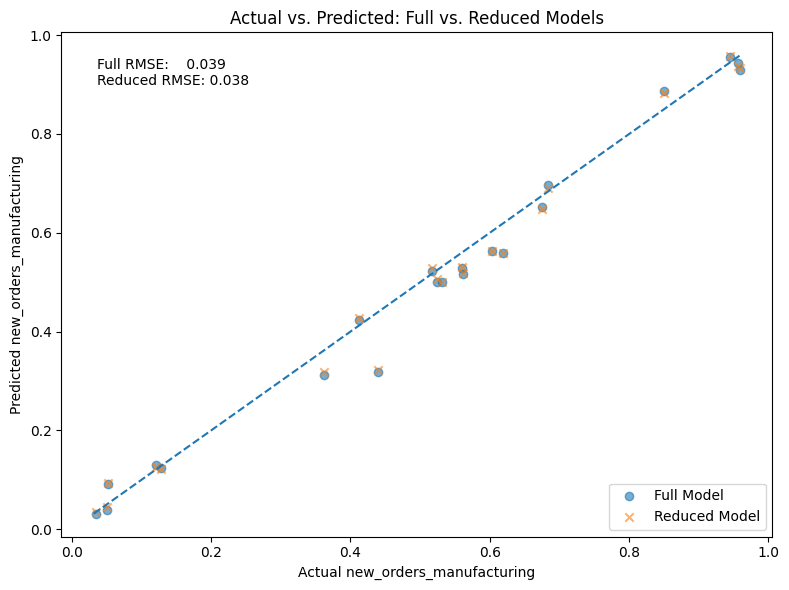

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot predictions
ax.scatter(y_te, y_pred_full, alpha=0.6, marker='o', label='Full Model')
ax.scatter(y_te, y_pred_red,  alpha=0.6, marker='x', label='Reduced Model')

# 45° reference line
lims = [min(y_te.min(), y_pred_full.min(), y_pred_red.min()),
        max(y_te.max(), y_pred_full.max(), y_pred_red.max())]
ax.plot(lims, lims, linestyle='--')

# Annotate model RMSEs
annotation = (
    f'Full RMSE:    {rmse_full:.3f}\n'
    f'Reduced RMSE: {rmse_red:.3f}'
)
ax.text(0.05, 0.95, annotation,
        transform=ax.transAxes,
        verticalalignment='top')

ax.set_xlabel('Actual new_orders_manufacturing')
ax.set_ylabel('Predicted new_orders_manufacturing')
ax.set_title('Actual vs. Predicted: Full vs. Reduced Models')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

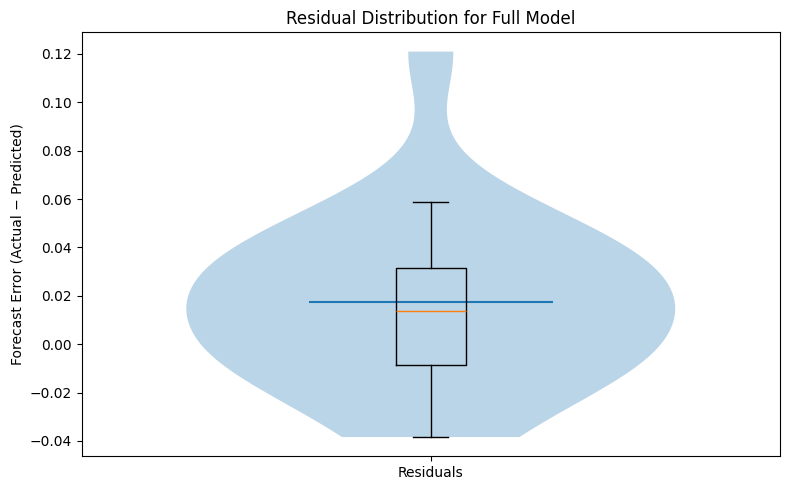

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reconstruct residuals and dates
resid_full = y_te - y_pred_full
dates = pd.to_datetime(df_nest.loc[y_te.index, 'Date'], format='%Y/%m')

# 1) Violin + Boxplot of residuals
fig, ax = plt.subplots(figsize=(8, 5))
ax.violinplot(resid_full, showmeans=True, showextrema=False, widths=0.7)
ax.boxplot(resid_full, positions=[1], widths=0.1, showfliers=False)
ax.set_xticks([1])
ax.set_xticklabels(['Residuals'])
ax.set_ylabel('Forecast Error (Actual − Predicted)')
ax.set_title('Residual Distribution for Full Model')
plt.tight_layout()
plt.show()

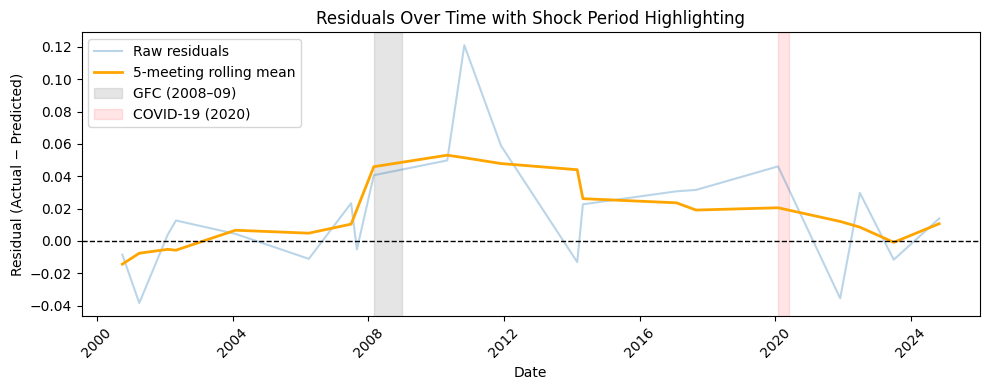

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Build a DataFrame of residuals + dates, then sort chronologically
df_err = pd.DataFrame({
    'Date': pd.to_datetime(df_nest.loc[y_te.index, 'Date'], format='%Y/%m'),
    'Residual': (y_te - y_pred_full).values
}).sort_values('Date')

dates_sorted = df_err['Date']
resid_sorted = df_err['Residual']

# 2) Compute a centered rolling mean (5‐meeting window)
rolling = resid_sorted.rolling(window=5, center=True, min_periods=1).mean()

# 3) Plot raw residuals, rolling mean, and shade shock periods
fig, ax = plt.subplots(figsize=(10, 4))

# Raw + smoothed residuals
ax.plot(dates_sorted, resid_sorted, alpha=0.3, label='Raw residuals')
ax.plot(dates_sorted, rolling,   color='orange', linewidth=2, label='5-meeting rolling mean')

# Shade Global Financial Crisis: Sep 2008 – Jun 2009
ax.axvspan(pd.Timestamp('2008-03-01'), pd.Timestamp('2009-01-01'),
           color='gray', alpha=0.2, label='GFC (2008–09)')

# Shade COVID-19 shock: Feb 2020 – Jun 2020
ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-06-01'),
           color='red', alpha=0.1, label='COVID-19 (2020)')

# Zero line and labels
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Residual (Actual − Predicted)')
ax.set_title('Residuals Over Time with Shock Period Highlighting')
ax.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 1) Compute residuals on the test set
residuals = y_te - y_pred_full

# 2) Build a DataFrame that ties together Date, cluster, actual, predicted, and error
error_df = pd.DataFrame({
    'Date':        df_nest.loc[y_te.index, 'Date'],        # e.g. "YYYY/MM"
    'Actual':      y_te.values,
    'Predicted':   y_pred_full,
    'Residual':    residuals.values
}, index=y_te.index)

# 3) Compute absolute error and sort
error_df['AbsError'] = np.abs(error_df['Residual'])
top10 = error_df.sort_values('AbsError', ascending=False).head(10)

print("Top 10 Largest Errors:")
print(top10[['Date','Actual','Predicted','Residual','AbsError']])

Top 10 Largest Errors:
        Date    Actual  Predicted  Residual  AbsError
95   2010/11  0.440111   0.319138  0.120973  0.120973
104  2011/12  0.618261   0.559392  0.058869  0.058869
90   2010/05  0.361865   0.312095  0.049770  0.049770
171  2020/02  0.562171   0.516097  0.046074  0.046074
70   2008/03  0.602944   0.562331  0.040614  0.040614
11   2001/04  0.052621   0.091009 -0.038388  0.038388
186  2021/12  0.850436   0.885930 -0.035494  0.035494
151  2017/09  0.560016   0.528485  0.031531  0.031531
146  2017/02  0.530958   0.500301  0.030657  0.030657
191  2022/07  0.959282   0.929598  0.029685  0.029685


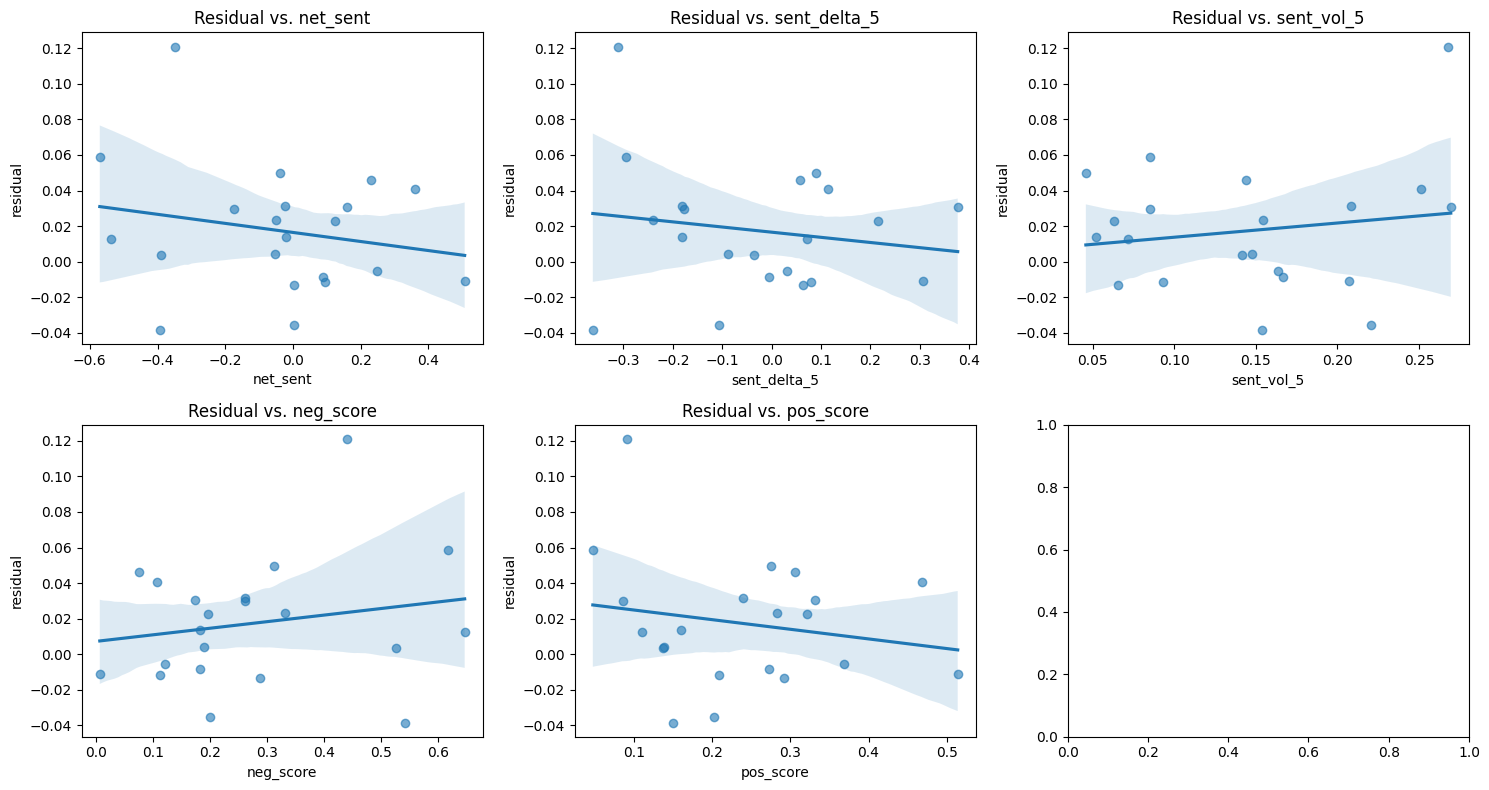

Pearson correlations:
  net_sent    : r = -0.202, p = 0.379
  sent_delta_5: r = -0.162, p = 0.483
  sent_vol_5  : r = 0.161, p = 0.486
  neg_score   : r = 0.188, p = 0.415
  pos_score   : r = -0.188, p = 0.414


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# 1) Reconstruct residuals
residuals = y_te - y_pred_full

# 2) Put residuals and sentiment into a DataFrame
err_sent = pd.DataFrame({
    'residual':   residuals.values,
    'net_sent':   df_nest.loc[y_te.index, 'net_sent'].values,
    'sent_delta_5': df_nest.loc[y_te.index, 'sent_delta_5'].values,
    'sent_vol_5':  df_nest.loc[y_te.index, 'sent_vol_5'].values,
    'neg_score':   df_nest.loc[y_te.index, 'neg_score'].values,
    'pos_score':   df_nest.loc[y_te.index, 'pos_score'].values,
})

# 3) Pairwise scatter + regression line
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, feat in zip(axes.flat, ['net_sent','sent_delta_5','sent_vol_5','neg_score','pos_score']):
    sns.regplot(x=feat, y='residual', data=err_sent, ax=ax, scatter_kws={'alpha':0.6})
    ax.set_title(f'Residual vs. {feat}')
plt.tight_layout()
plt.show()

# 4) Compute correlations
print("Pearson correlations:")
for feat in ['net_sent','sent_delta_5','sent_vol_5','neg_score','pos_score']:
    r, p = pearsonr(err_sent['residual'], err_sent[feat])
    print(f"  {feat:12s}: r = {r:.3f}, p = {p:.3f}")

# Appendix2 - Advanced Grid Search on Supervised Learning

In [ ]:
import pandas as pd
df_data = pd.read_csv("clean_data.csv")
df = df_data[['score_minute', 'score_statement', 'CPI', 'PPI', 'oil_prices', 'unemployment', 'GSCPI', 'shipment_idx']]
X = df
feature_names = X.columns.to_list()
feature_names
# create target variable
y = df_data['new_orders_manufacturing']
y.shape
# splite the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 8), (61, 8), (240,), (61,))

In [ ]:
#  GridSearch + Extended Evaluation Metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 1) Set up grid search
dtr = DecisionTreeRegressor(random_state=42)
param_grid = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random']
}

grid = GridSearchCV(
    estimator=dtr,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

# 2) Fit!
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

# 3) Predict on test set
best_dt = grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)

# 4) Compute metrics
r2   = r2_score(y_test, y_pred_dt)
mae  = mean_absolute_error(y_test, y_pred_dt)
mse  = mean_squared_error(y_test, y_pred_dt)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred_dt)

print(f"Test R²   : {r2:.3f}")
print(f"Test MAE  : {mae:.3f}")
print(f"Test RMSE  : {rmse:.3f}")
print(f"Test MAPE : {mape:.2%}")

Best params: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Test R²   : 0.916
Test MAE  : 0.053
Test RMSE  : 0.082
Test MAPE : 12.98%


In [ ]:
# get top 10 feature importances
importances = best_dt.feature_importances_
indices = importances.argsort()[::-1][:10]
print("Top 10 feature importances:")
for f in range(len(indices)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")

Top 10 feature importances:
1. oil_prices (0.428)
2. PPI (0.228)
3. CPI (0.167)
4. shipment_idx (0.054)
5. unemployment (0.048)
6. score_statement (0.033)
7. score_minute (0.021)
8. GSCPI (0.021)


In [ ]:
# Advanced Grid/Random Search + Multi‐Metric Evaluation for Random Forest
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 1) Define estimator and parameter distributions
rfr = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators':      [50, 100, 200, 400],
    'max_depth':         [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 'log2']
}

# 2) Define multiple scoring metrics
scoring = {
    'R2':  'r2',
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error'
}

# 3) Set up RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_dist,
    n_iter=50,                # number of random draws
    cv=5,                     # 5‐fold CV
    scoring=scoring,
    refit='R2',               # use R2 to pick the best model
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

# 4) Fit on training data
rs.fit(X_train, y_train)
print("Best hyper‐parameters:", rs.best_params_, "\n")

# 6) Evaluate hold-out test performance
best_rf = rs.best_estimator_
y_pred_rf = best_rf.predict(X_test)

r2   = r2_score(y_test, y_pred_rf)
mae  = mean_absolute_error(y_test, y_pred_rf)
mse  = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)

print("Hold-out Test Performance:")
print(f"  R²   : {r2:.3f}")
print(f"  MAE  : {mae:.3f}")
print(f"  RMSE : {rmse:.3f}")
print(f"  MAPE : {mape:.2%}")

Best hyper‐parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10} 

Hold-out Test Performance:
  R²   : 0.977
  MAE  : 0.031
  RMSE : 0.043
  MAPE : 11.12%


In [ ]:
# get top 10 feature importances
importances = best_rf.feature_importances_
indices = importances.argsort()[::-1][:10]
print("Top 10 feature importances:")
for f in range(len(indices)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")

Top 10 feature importances:
1. PPI (0.457)
2. oil_prices (0.245)
3. unemployment (0.079)
4. shipment_idx (0.076)
5. CPI (0.075)
6. score_minute (0.031)
7. score_statement (0.020)
8. GSCPI (0.017)


In [ ]:
# Advanced Randomized Search + Multi-Metric Evaluation for XGBRegressor
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 1) Split off a small validation set for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

# 2) Define estimator and parameter distributions
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",        # faster grow
    verbosity=0
)
param_dist = {
    'n_estimators':      [100, 200, 400, 800],
    'max_depth':         [3, 5, 7, 10],
    'learning_rate':     [0.01, 0.03, 0.05, 0.1],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 1, 5],
    'reg_alpha':         [0, 0.1, 1],
    'reg_lambda':        [1, 5, 10]
}

# 3) Define multiple scoring metrics
scoring = {
    'R2':  'r2',
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error'
}

# 4) Set up RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=60,               # number of random draws
    cv=4,                    # 4-fold CV on X_tr
    scoring=scoring,
    refit='R2',              # pick best by R2
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

# 5) Fit with early stopping on the held-out validation set
rs.fit(
    X_tr, y_tr,
    **{
        "eval_set":       [(X_val, y_val)],
        "verbose":        False
    }
)

print("Best hyper-parameters:\n", rs.best_params_, "\n")

Best hyper-parameters:
 {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0} 



In [ ]:
# get top 10 feature importances
importances = rs.best_estimator_.feature_importances_
indices = importances.argsort()[::-1][:10]
print("Top 10 feature importances:")
for f in range(len(indices)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")

Top 10 feature importances:
1. PPI (0.808)
2. oil_prices (0.107)
3. shipment_idx (0.033)
4. unemployment (0.030)
5. score_minute (0.010)
6. CPI (0.006)
7. score_statement (0.004)
8. GSCPI (0.003)


In [ ]:
# get top 10 feature importances
importances = rs.best_estimator_.feature_importances_
indices = importances.argsort()[::-1][:10]
print("Top 10 feature importances:")
for f in range(len(indices)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")

Top 10 feature importances:
1. PPI (0.808)
2. oil_prices (0.107)
3. shipment_idx (0.033)
4. unemployment (0.030)
5. score_minute (0.010)
6. CPI (0.006)
7. score_statement (0.004)
8. GSCPI (0.003)


In [ ]:
# 7) Evaluate hold-out test performance
best_xgb = rs.best_estimator_
y_pred = best_xgb.predict(X_test)

metrics = {
    "R2":   r2_score(y_test, y_pred),
    "MAE":  mean_absolute_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred)
}

print("Hold-out Test Performance:")
for name, val in metrics.items():
    if name == "MAPE":
        print(f"  {name:>4} : {val:.2%}")
    else:
        print(f"  {name:>4} : {val:.4f}")

Hold-out Test Performance:
    R2 : 0.9748
   MAE : 0.0311
  RMSE : 0.0449
  MAPE : 10.92%


In [ ]:
# get top 10 feature importances
importances = best_xgb.feature_importances_
indices = importances.argsort()[::-1][:10]
print("Top 10 feature importances:")
for f in range(len(indices)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")

Top 10 feature importances:
1. PPI (0.808)
2. oil_prices (0.107)
3. shipment_idx (0.033)
4. unemployment (0.030)
5. score_minute (0.010)
6. CPI (0.006)
7. score_statement (0.004)
8. GSCPI (0.003)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 1) Build a pipeline that can optionally add polynomial features
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("lr", LinearRegression())
])

# 2) Define hyper‐parameters to search
param_grid = {
    "poly__degree":        [1, 2, 3],           # try linear up to cubic
    "lr__fit_intercept":   [True, False]
}

# 3) Define multi‐metric scoring
scoring = {
    "R2":  "r2",
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error"
}

# 4) Set up GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                    # 5‐fold CV
    scoring=scoring,
    refit="R2",              # choose best by R2
    return_train_score=True,
    n_jobs=-1
)

# 5) Fit on training data
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_, "\n")

Best params: {'lr__fit_intercept': True, 'poly__degree': 2} 



In [ ]:
# 7) Evaluate on hold‐out test set
best_pipe = grid.best_estimator_
y_pred = best_pipe.predict(X_test)

metrics = {
    "R2":   r2_score(y_test, y_pred),
    "MAE":  mean_absolute_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred)
}

print("Hold‐out Test Performance:")
for name, val in metrics.items():
    if name == "MAPE":
        print(f"  {name:>4} : {val:.2%}")
    else:
        print(f"  {name:>4} : {val:.4f}")

Hold‐out Test Performance:
    R2 : 0.9734
   MAE : 0.0316
  RMSE : 0.0462
  MAPE : 14.04%
